# IMAT data vertical settings: peak fitting
## In this notebook I start from the spectra saved in the Imat_data_verticalSettings notebook, and apply peak fitting in selected peaks. 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os, fnmatch
from os import listdir
#%matplotlib inline
%matplotlib notebook
import scipy.signal
import matplotlib.patches as patches
from skimage.filters import threshold_otsu
from scipy.stats import binned_statistic
from scipy.signal import resample
from scipy.signal import argrelextrema

import AdvancedBraggEdgeFitting
import TOF_routines
from TOF_routines import binning
from TOF_routines import tof2l
from TOF_routines import l2tof
from TOF_routines import find_nearest

In [2]:
# here now I put the number obtained from the flight-path calibration
t0 =  0.0002466
L = 56.065
lambda0 = 0.017
dL = 0

In [4]:
# Load of computed spectra for the selected ROIs
stress_304 = np.loadtxt('spectrum_stress_304.txt')
ob_304 = np.loadtxt('spectrum_ob_stress_304.txt')
stress_316 = np.loadtxt('spectrum_stress_316.txt')
ob_316 = np.loadtxt('spectrum_ob_stress_316.txt')

# stress_304 = np.loadtxt('spectrum_ref_304.txt')
# ob_304 = np.loadtxt('spectrum_ob_ref_304.txt')
# stress_316 = np.loadtxt('spectrum_ref_316.txt')
# ob_316 = np.loadtxt('spectrum_ob_ref_316.txt')


# Load TOF
myTOF = np.genfromtxt('/media/carminati_c/Data2/IMAT_Nov2018/03_VerticalSetting_3hruns/Flat1_Corrected/IMAT00010433_VerticalSetting_2hruns_000_Spectra.txt', usecols=0)

In [ ]:
# Load some theoretical values
mylambda = np.genfromtxt('lambda.txt',usecols=0)
myalpha = np.genfromtxt('alpha.txt',usecols=0)
mygamma = np.genfromtxt('gamma.txt',usecols=0)

dhkl_alphaFe = np.genfromtxt('alphaFe_hkl', usecols=4)
h_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=0)
k_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=1)
l_alphaFe= np.genfromtxt('alphaFe_hkl', usecols=2)

dhkl_gammaFe = np.genfromtxt('gammaFe_hkl', usecols=4)
h_gammaFe= np.genfromtxt('gammaFe_hkl', usecols=0)
k_gammaFe= np.genfromtxt('gammaFe_hkl', usecols=1)
l_gammaFe= np.genfromtxt('gammaFe_hkl', usecols=2)

In [ ]:
# Angle by angle comparison, now normalization by the last part
stress304_spectrum_norm=(stress_304[0][:]/ob_304[0][:])
last_part_304 = np.mean(stress304_spectrum_norm[1500:2000]) 
stress304_spectrum_norm = stress304_spectrum_norm/last_part_304
stress304_spectrum_binned = TOF_routines.binning(stress304_spectrum_norm, 350)
stress316_spectrum_norm=(stress_316[0][:]/ob_316[0][:])
last_part_316 = np.mean(stress316_spectrum_norm[1500:2000])      
stress316_spectrum_norm= stress316_spectrum_norm/last_part_316
stress316_spectrum_binned = TOF_routines.binning(stress316_spectrum_norm, 350)
plt.plot(binning(tof2l(myTOF, lambda0,t0,L),350), -1*np.log(stress304_spectrum_binned))
plt.plot(binning(tof2l(myTOF, lambda0,t0,L),350), -1*np.log(stress316_spectrum_binned))

for i in range(0,7):
    if i==0:
        plt.plot(np.array([2*dhkl_alphaFe[i],2*dhkl_alphaFe[i]]), np.array([-0.05,0.3]), '--b',label=r'$\alpha$ Fe - Martensite')
    else:
        plt.plot(np.array([2*dhkl_alphaFe[i],2*dhkl_alphaFe[i]]), np.array([-0.05,0.3]), '--b')
    mytext = '('+str((h_alphaFe[i]).astype(int))+','+str(k_alphaFe[i].astype(int))+','+str(l_alphaFe[i].astype(int))+')'
    plt.text(2*dhkl_alphaFe[i],0.35, mytext, rotation=45, color='b')

for i in range(0,7):
    if i==0:
        plt.plot(np.array([2*dhkl_gammaFe[i],2*dhkl_gammaFe[i]]), np.array([-0.05,0.3]), '--g', label=r'$\gamma$ Fe - Austenite')
    else:
        plt.plot(np.array([2*dhkl_gammaFe[i],2*dhkl_gammaFe[i]]), np.array([-0.05,0.3]), '--g')                    

    mytext = '('+str((h_gammaFe[i]).astype(int))+','+str(k_gammaFe[i].astype(int))+','+str(l_gammaFe[i].astype(int))+')'
    plt.text(2*dhkl_gammaFe[i],-0.05, mytext, rotation=45, color='g')

In [6]:
print(2*dhkl_gammaFe[:])

[4.142 3.588 2.536 2.164 2.07  1.794 1.646 1.604 1.464 1.38  1.38  1.268
 1.212 1.196 1.196 1.134 1.094 1.082 1.036 1.004 1.004 0.994 0.958 0.934
 0.934 0.896 0.876 0.87  0.87  0.846 0.846 0.828 0.828 0.822 0.802 0.788
 0.782 0.764 0.732 0.722 0.722 0.718 0.704 0.694 0.69  0.666 0.646 0.634
 0.624 0.616 0.598 0.592 0.56  0.518]


In [7]:
# Here I create the spectra only once, since I then use parts of them for the peak fitting
stress304_spectrum_binned =[]
stress316_spectrum_binned =[]

for i in range(0, len(stress_304)):
    stress304_spectrum_norm=(stress_304[i][:]/ob_304[i][:]) # This is now already computed at the beginnig
    last_part_304 =  np.mean(stress304_spectrum_norm[1500:2000]) 
    stress304_spectrum_norm = stress304_spectrum_norm/last_part_304
    stress304_spectrum_binned.append(binning(stress304_spectrum_norm, 350))
    stress316_spectrum_norm=(stress_316[i][:]/ob_316[i][:])
    last_part_316 = np.mean(stress316_spectrum_norm[1500:2000])
    stress316_spectrum_norm = stress316_spectrum_norm/last_part_316
    stress316_spectrum_binned.append(binning(stress316_spectrum_norm, 350))

Text(0.5, 1.0, '(1,1,1)')

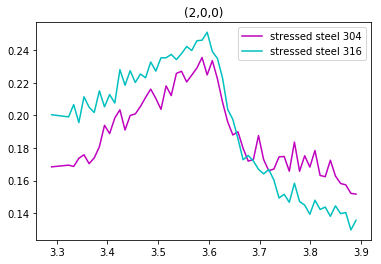

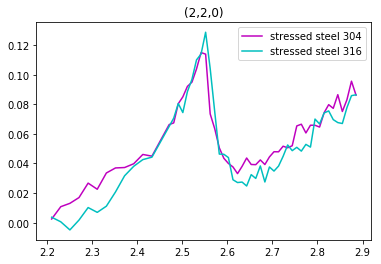

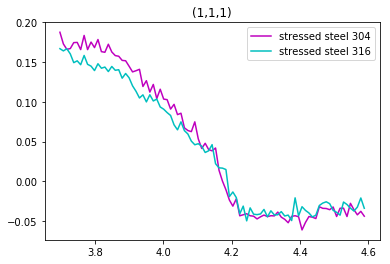

In [8]:
# Here I define the peak position and the range for the three studied edges

mylambda_binned = binning(tof2l(myTOF, lambda0,t0,L),350)
peak_position_200 = find_nearest(mylambda_binned, 3.588)
# peak_position_200 = find_nearest(mylambda_binned, 3.62) # trying to change this for the ref sample. It worked
lambda_range_200 = [3.3, 3.9]
myrange_200 = np.array([find_nearest(mylambda_binned, lambda_range_200[0]), find_nearest(mylambda_binned, lambda_range_200[1])])

plt.figure()
plt.plot(mylambda_binned[myrange_200[0]:myrange_200[1]], -1*np.log(stress304_spectrum_binned[0][myrange_200[0]:myrange_200[1]]), label='stressed steel 304', color='m') # this is possibly the range to be used for the peak fitting
plt.plot(mylambda_binned[myrange_200[0]:myrange_200[1]], -1*np.log(stress316_spectrum_binned[0][myrange_200[0]:myrange_200[1]]), label='stressed steel 316', color='c')
plt.legend(loc='upper right')
plt.title('(2,0,0)')


peak_position_220 = find_nearest(mylambda_binned, 2.536)
lambda_range1 = find_nearest(mylambda_binned, 2.2)
lambda_range2 = find_nearest(mylambda_binned, 2.9)
myrange_220 = [lambda_range1, lambda_range2]

plt.figure()
plt.plot(mylambda_binned[myrange_220[0]:myrange_220[1]], -1*np.log(stress304_spectrum_binned[0][myrange_220[0]:myrange_220[1]]), label='stressed steel 304', color='m') # this is possibly the range to be used for the peak fitting
plt.plot(mylambda_binned[myrange_220[0]:myrange_220[1]], -1*np.log(stress316_spectrum_binned[0][myrange_220[0]:myrange_220[1]]), label='stressed steel 316', color='c')
plt.legend(loc='upper right')
plt.title('(2,2,0)')

peak_position_111 = find_nearest(mylambda_binned, 4.142)
lambda_range1 = find_nearest(mylambda_binned, 3.7)
lambda_range2 = find_nearest(mylambda_binned, 4.6)
myrange_111 = [lambda_range1, lambda_range2]

plt.figure()
plt.plot(mylambda_binned[myrange_111[0]:myrange_111[1]], -1*np.log(stress304_spectrum_binned[0][myrange_111[0]:myrange_111[1]]), label='stressed steel 304', color='m') # this is possibly the range to be used for the peak fitting
plt.plot(mylambda_binned[myrange_111[0]:myrange_111[1]], -1*np.log(stress316_spectrum_binned[0][myrange_111[0]:myrange_111[1]]), label='stressed steel 316', color='c')
plt.legend(loc='upper right')
plt.title('(1,1,1)')

## Here I run the peak fitting for all studied peaks in a loop 

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 24
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00178566
    reduced chi-square = 3.5013e-05
    Akaike info crit   = -588.527775
    Bayesian info crit = -574.104674
[[Variables]]
    t0:     30.7898691 +/- 0.79658424 (2.59%) (init = 35.48051)
    sigma: -1.68376581 +/- 0.84456147 (50.16%) (init = -0.04829532)
    alpha: -0.87449594 +/- 0.97264869 (111.22%) (init = -16.40015)
    a1:     0.20138909 +/- 0.00439438 (2.18%) (init = 0.2026523)
    a2:     7.3271e-04 +/- 1.2067e-04 (16.47%) (init = 0.001764924)
    a5:    -0.00275750 +/- 2.9510e-04 (10.70%) (init = -0.00375923)
    a6:     14.1029565 +/- 1.79097673 (12.70%) (init = 12.21577)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  0.964
    C(a1, a5)       = -0.947
    C(a5, a6)       = -0.918
    C(t0, alpha)    = -0.877
    C(t0, sigm

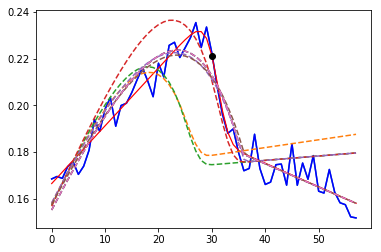

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 23
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00112321
    reduced chi-square = 2.2024e-05
    Akaike info crit   = -615.416320
    Bayesian info crit = -600.993219
[[Variables]]
    t0:     31.5289402 +/- 0.24453367 (0.78%) (init = 36.37356)
    sigma: -2.32522691 +/- 0.29400719 (12.64%) (init = -0.5797424)
    alpha: -0.38392205 +/- 49008.0480 (12765103.80%) (init = -17.02885)
    a1:     0.21392087 +/- 0.00342117 (1.60%) (init = 0.2202668)
    a2:     6.9641e-05 +/- 1.1589e-04 (166.41%) (init = 0.001267502)
    a5:    -0.00347943 +/- 2.6413e-04 (7.59%) (init = -0.005051419)
    a6:     8.97841539 +/- 1.85601976 (20.67%) (init = 9.642331)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)    =  0.955
    C(a5, a6)    = -0.943
    C(a1, a5)    = -0.923
    C(a1, a2)    = -0.749
    C(a2, a6)    = -0

/home/carminati_c/git/scripts/python/ToF_notebooks/AdvancedBraggEdgeFitting.py:22: RuntimeWarning: overflow encountered in exp
  return np.exp(-((t-t0)/alpha) + ((sigma*sigma)/(2*alpha*alpha)))
/home/carminati_c/git/scripts/python/ToF_notebooks/AdvancedBraggEdgeFitting.py:68: RuntimeWarning: invalid value encountered in multiply
  return a1 + term0(t,a2,a6) + term1(t,a2,a5,a6) * (1-(term3(t,t0,sigma) - term4(t,t0,alpha,sigma)* term5(t,t0,alpha,sigma)))


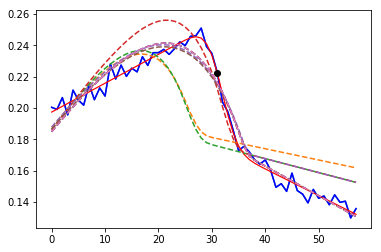

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 25
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00191684
    reduced chi-square = 4.0784e-05
    Akaike info crit   = -539.287184
    Bayesian info crit = -525.364295
[[Variables]]
    t0:     21.7440147 (init = 26.38957)
    sigma: -1.59842218 (init = -0.722306)
    alpha: -0.08577889 (init = -15.47714)
    a1:    -0.03088220 (init = -0.03855934)
    a2:     0.00387752 (init = 0.006534838)
    a5:     1.8272e-04 (init = -0.001991638)
    a6:    -5.00507255 (init = -3.12153)



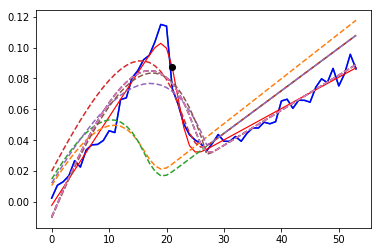

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 31
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00302453
    reduced chi-square = 6.4352e-05
    Akaike info crit   = -514.659095
    Bayesian info crit = -500.736207
[[Variables]]
    t0:     22.3953278 (init = 27.08236)
    sigma: -1.63989725 (init = -0.5340084)
    alpha: -0.17049466 (init = -15.84876)
    a1:    -0.04330386 (init = -0.04978401)
    a2:     0.00446712 (init = 0.007601878)
    a5:    -7.5183e-05 (init = -0.002761485)
    a6:    -3.77198317 (init = -1.958483)



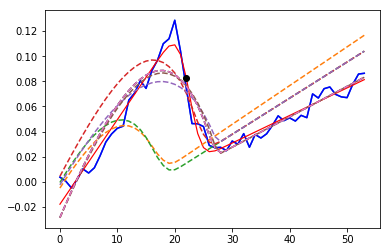

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 700
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00284418
    reduced chi-square = 3.5552e-05
    Akaike info crit   = -884.569934
    Bayesian info crit = -867.308577
[[Variables]]
    t0:     45.5298229 +/- 2.55927917 (5.62%) (init = 48.33861)
    sigma: -7.27910184 +/- 1.91392165 (26.29%) (init = -2.25315)
    alpha: -7.37272440 +/- 1.65035600 (22.38%) (init = -0.2645192)
    a1:    -0.00218323 +/- 0.01858602 (851.31%) (init = -0.04301929)
    a2:    -3.5452e-04 +/- 2.2597e-04 (63.74%) (init = -0.002019005)
    a5:     0.00170655 +/- 2.6208e-04 (15.36%) (init = 0.002577349)
    a6:     132.532490 +/- 21.7736404 (16.43%) (init = 59.21497)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)       =  0.999
    C(t0, sigma)    =  0.954
    C(a1, a6)       =  0.844
    C(a2, a6)       =  0.838
    C(t0, a

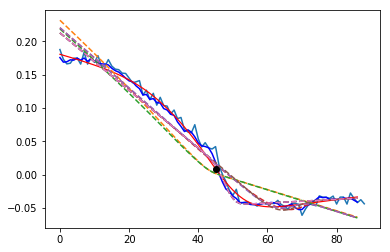

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 149
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00218655
    reduced chi-square = 2.7332e-05
    Akaike info crit   = -907.446376
    Bayesian info crit = -890.185019
[[Variables]]
    t0:     48.3370927 +/- 2.46990771 (5.11%) (init = 49.50401)
    sigma: -5.59094879 +/- 2.05177419 (36.70%) (init = -1.688158)
    alpha: -4.95987009 +/- 1.46680861 (29.57%) (init = -0.141624)
    a1:    -0.03075407 +/- 0.00262597 (8.54%) (init = -0.03798537)
    a2:    -9.1022e-04 +/- 1.1124e-04 (12.22%) (init = -0.001778519)
    a5:     0.00201554 +/- 2.0232e-04 (10.04%) (init = 0.002287398)
    a6:     83.3473986 +/- 3.83461338 (4.60%) (init = 58.94566)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, sigma)    =  0.947
    C(a1, a2)       =  0.932
    C(t0, alpha)    = -0.911
    C(sigma, alpha) = -0.839
    C(a1, a6) 

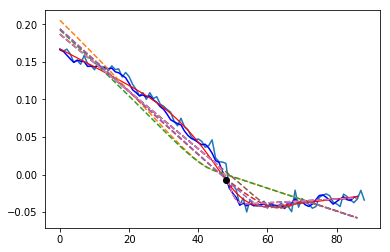

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 44
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00252019
    reduced chi-square = 4.9416e-05
    Akaike info crit   = -568.544011
    Bayesian info crit = -554.120909
[[Variables]]
    t0:     32.2960618 +/- 0.75527453 (2.34%) (init = 35)
    sigma: -0.40996545 +/- 0.76350443 (186.24%) (init = -5.423399e-07)
    alpha: -2.10759784 +/- 1.12431847 (53.35%) (init = -14.39042)
    a1:     0.19898363 +/- 0.00462024 (2.32%) (init = 0.199862)
    a2:     7.0171e-04 +/- 1.4082e-04 (20.07%) (init = 0.001626107)
    a5:    -0.00279512 +/- 3.2103e-04 (11.49%) (init = -0.003670449)
    a6:     13.7285835 +/- 1.91621610 (13.96%) (init = 11.90826)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  0.951
    C(a1, a5)       = -0.932
    C(a5, a6)       = -0.889
    C(t0, alpha)    = -0.881
    C(a2, a6)     

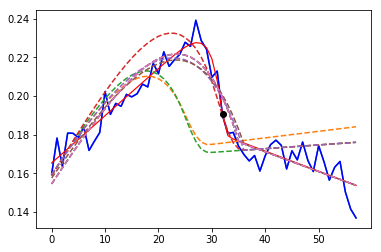

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 41
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00262706
    reduced chi-square = 5.1511e-05
    Akaike info crit   = -566.135353
    Bayesian info crit = -551.712252
[[Variables]]
    t0:     32.8757139 +/- 3.02268652 (9.19%) (init = 36.5915)
    sigma: -1.26035763 +/- 1.61561487 (128.19%) (init = -0.05140944)
    alpha: -2.09839172 +/- 2.68491174 (127.95%) (init = -18.42499)
    a1:     0.20828156 +/- 0.00490996 (2.36%) (init = 0.2112421)
    a2:     1.5356e-04 +/- 1.6122e-04 (104.99%) (init = 0.001434325)
    a5:    -0.00346013 +/- 3.8692e-04 (11.18%) (init = -0.004815104)
    a6:     10.3631624 +/- 2.49356199 (24.06%) (init = 9.445843)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, alpha)    = -0.986
    C(t0, sigma)    =  0.969
    C(a1, a6)       =  0.953
    C(sigma, alpha) = -0.946
    C(a5, a6

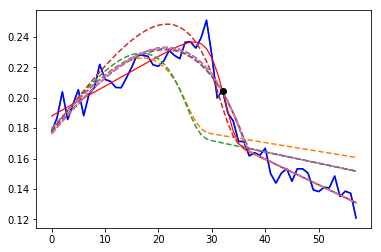

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 28
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00327337
    reduced chi-square = 6.9646e-05
    Akaike info crit   = -510.389691
    Bayesian info crit = -496.466803
[[Variables]]
    t0:     21.9415120 (init = 26.83762)
    sigma: -1.59249524 (init = -1.019088)
    alpha: -0.19302969 (init = -15.70085)
    a1:    -0.04176196 (init = -0.05813551)
    a2:     0.00439213 (init = 0.007040247)
    a5:    -1.2970e-04 (init = -0.002147365)
    a6:     0.12646635 (init = -0.8188783)



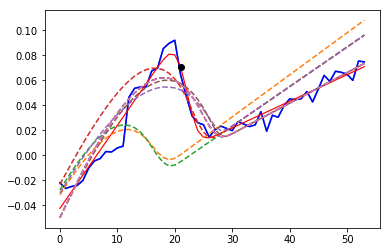

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 36
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00480144
    reduced chi-square = 1.0216e-04
    Akaike info crit   = -489.702510
    Bayesian info crit = -475.779621
[[Variables]]
    t0:     21.8647464 (init = 27.06552)
    sigma: -1.35113578 (init = -1.254074)
    alpha: -0.10588678 (init = -15.81064)
    a1:    -0.03050907 (init = -0.06077111)
    a2:     0.00514757 (init = 0.008482618)
    a5:    -0.00143301 (init = -0.003634792)
    a6:     3.95782123 (init = 1.00441)



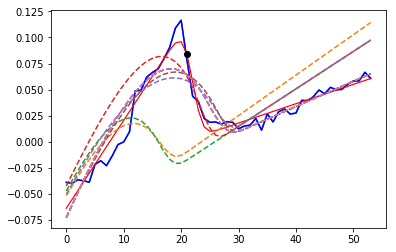

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 42
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00619748
    reduced chi-square = 7.7468e-05
    Akaike info crit   = -816.808298
    Bayesian info crit = -799.546941
[[Variables]]
    t0:     46.3092790 (init = 48.99307)
    sigma: -4.59212819 (init = -2.848101)
    alpha: -0.15300675 (init = -0.1530067)
    a1:    -0.03966046 (init = -0.05096812)
    a2:    -0.00128599 (init = -0.00169516)
    a5:     0.00255666 (init = 0.003441054)
    a6:     73.6798282 (init = 61.78806)

0.0


/home/carminati_c/git/scripts/python/ToF_notebooks/AdvancedBraggEdgeFitting.py:45: RuntimeWarning: invalid value encountered in multiply
  return (1-(term3(t,t0,sigma) - term4(t,t0,alpha,sigma)* term5(t,t0,alpha,sigma)))


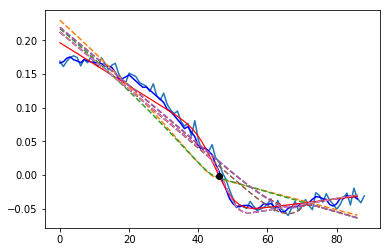

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 243
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00305109
    reduced chi-square = 3.8139e-05
    Akaike info crit   = -878.460340
    Bayesian info crit = -861.198983
[[Variables]]
    t0:     48.5438626 +/- 2.11939083 (4.37%) (init = 49.21719)
    sigma: -5.78494350 +/- 2.10146117 (36.33%) (init = -1.737308)
    alpha: -4.54272673 +/- 1.28549065 (28.30%) (init = -0.192817)
    a1:    -0.03086276 +/- 0.00334018 (10.82%) (init = -0.04115067)
    a2:    -8.0792e-04 +/- 1.2808e-04 (15.85%) (init = -0.001730411)
    a5:     0.00240748 +/- 2.5002e-04 (10.39%) (init = 0.002542157)
    a6:     81.6425978 +/- 3.71493154 (4.55%) (init = 58.95695)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, sigma)    =  0.920
    C(a1, a2)       =  0.892
    C(t0, alpha)    = -0.870
    C(a1, a6)       =  0.845
    C(sigma, 

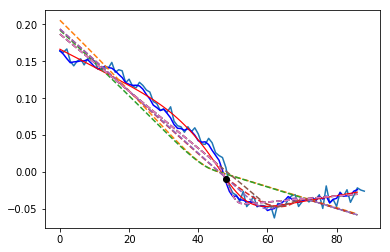

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 27
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00203748
    reduced chi-square = 3.9951e-05
    Akaike info crit   = -580.876211
    Bayesian info crit = -566.453110
[[Variables]]
    t0:     29.8591755 +/- 0.82616491 (2.77%) (init = 34.17286)
    sigma: -1.47223411 +/- 0.91703236 (62.29%) (init = -0.214011)
    alpha: -0.70138778 +/- 1.26433650 (180.26%) (init = -13.12137)
    a1:     0.19648924 +/- 0.00392160 (2.00%) (init = 0.1962605)
    a2:     6.0608e-04 +/- 1.2297e-04 (20.29%) (init = 0.001423072)
    a5:    -0.00269587 +/- 2.8964e-04 (10.74%) (init = -0.003379178)
    a6:     15.1660182 +/- 1.76072493 (11.61%) (init = 12.91966)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  0.943
    C(a1, a5)       = -0.939
    C(a5, a6)       = -0.885
    C(t0, alpha)    = -0.864
    C(t0, sigma

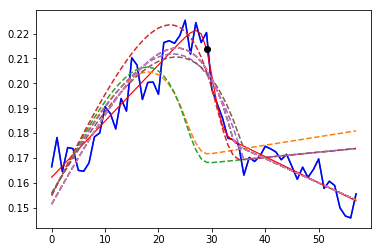

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 25
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00241312
    reduced chi-square = 4.7316e-05
    Akaike info crit   = -571.062192
    Bayesian info crit = -556.639091
[[Variables]]
    t0:     31.1307980 (init = 35.16803)
    sigma: -0.94740848 (init = -0.03423112)
    alpha: -0.07248844 (init = -14.76251)
    a1:     0.19975713 (init = 0.2018012)
    a2:     2.0684e-04 (init = 0.001386296)
    a5:    -0.00309954 (init = -0.00428125)
    a6:     11.0267819 (init = 9.590494)



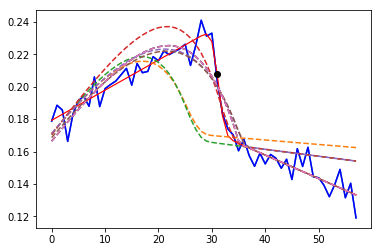

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 32
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00192040
    reduced chi-square = 4.0860e-05
    Akaike info crit   = -539.187167
    Bayesian info crit = -525.264279
[[Variables]]
    t0:     22.1666079 (init = 26.88468)
    sigma: -2.18958639 (init = -0.7957345)
    alpha: -0.08385209 (init = -16.2547)
    a1:    -0.06017629 (init = -0.05284356)
    a2:     0.00359056 (init = 0.006072794)
    a5:     6.3304e-04 (init = -0.001624247)
    a6:    -10.9739603 (init = -4.852073)



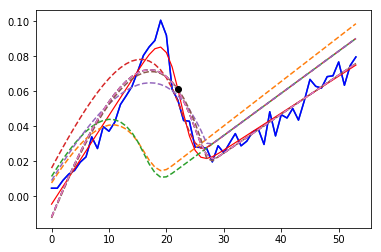

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 31
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00207003
    reduced chi-square = 4.4043e-05
    Akaike info crit   = -535.135594
    Bayesian info crit = -521.212706
[[Variables]]
    t0:     22.0542841 (init = 26.66681)
    sigma: -1.29849187 (init = -0.9940707)
    alpha: -0.08657430 (init = -15.83725)
    a1:    -0.03907529 (init = -0.05113653)
    a2:     0.00398619 (init = 0.006994903)
    a5:    -1.2297e-04 (init = -0.002528792)
    a6:    -3.35971744 (init = -2.29567)



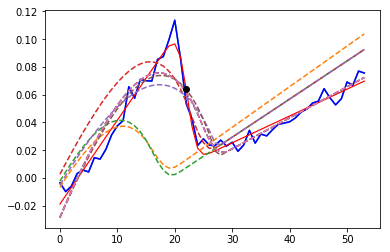

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 700
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00148128
    reduced chi-square = 1.8516e-05
    Akaike info crit   = -941.326121
    Bayesian info crit = -924.064764
[[Variables]]
    t0:     51.2468181 +/- 0.32416295 (0.63%) (init = 67.62461)
    sigma: -0.50140637 +/- 0.72875753 (145.34%) (init = -0.6765403)
    alpha: -23.8031395 +/- 7.21002541 (30.29%) (init = -5.933241)
    a1:     0.79013307 +/- 12.2576143 (1551.34%) (init = -0.03196285)
    a2:     1.6740e-04 +/- 4.4314e-04 (264.71%) (init = -0.00232228)
    a5:     2.2895e-04 +/- 4.5779e-04 (199.96%) (init = 0.001604851)
    a6:     4270.13198 +/- 61987.1329 (1451.64%) (init = 56.50947)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  1.000
    C(alpha, a1)    = -0.991
    C(a1, a2)       =  0.990
    C(alpha, a6)    = -0.990
    C

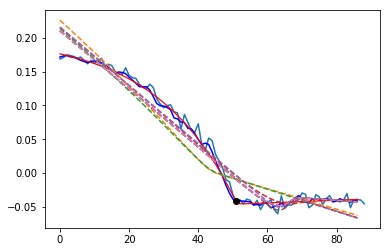

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 41
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00389138
    reduced chi-square = 4.8642e-05
    Akaike info crit   = -857.296279
    Bayesian info crit = -840.034922
[[Variables]]
    t0:     48.4242086 (init = 48.99248)
    sigma: -3.63301012 (init = -1.258842)
    alpha: -0.12646197 (init = -0.126462)
    a1:    -0.03977477 (init = -0.04082368)
    a2:    -0.00107545 (init = -0.001815166)
    a5:     0.00256917 (init = 0.002340449)
    a6:     74.0793836 (init = 59.52216)

0.0


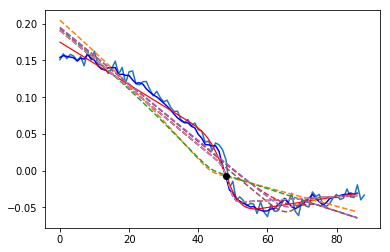

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 22
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00144178
    reduced chi-square = 2.8270e-05
    Akaike info crit   = -600.934387
    Bayesian info crit = -586.511286
[[Variables]]
    t0:     30.3322011 (init = 34.02884)
    sigma: -1.25620891 (init = -0.004286267)
    alpha: -0.15150619 (init = -12.60731)
    a1:     0.17866133 (init = 0.1797814)
    a2:     8.4633e-04 (init = 0.00174083)
    a5:    -0.00204340 (init = -0.002962155)
    a6:     10.9673553 (init = 9.718502)



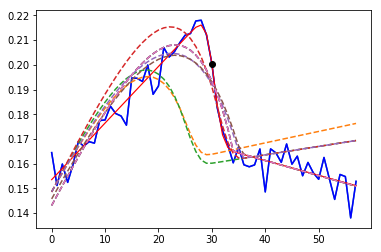

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 20
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00241874
    reduced chi-square = 4.7426e-05
    Akaike info crit   = -570.927274
    Bayesian info crit = -556.504173
[[Variables]]
    t0:     31.3730271 (init = 36.1941)
    sigma: -1.79786486 (init = -0.4357553)
    alpha: -0.09363672 (init = -17.21222)
    a1:     0.16872622 (init = 0.1714968)
    a2:     5.3275e-04 (init = 0.001671007)
    a5:    -0.00215627 (init = -0.003457177)
    a6:     5.95060275 (init = 6.771162)



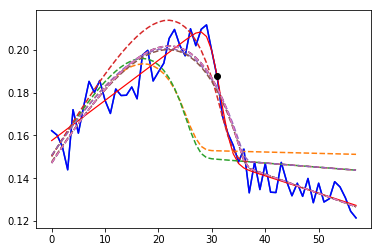

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 25
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00263129
    reduced chi-square = 5.5985e-05
    Akaike info crit   = -522.180255
    Bayesian info crit = -508.257367
[[Variables]]
    t0:     22.0195965 (init = 26.85132)
    sigma: -2.06320825 (init = -0.8212583)
    alpha: -0.28058110 (init = -15.96436)
    a1:    -0.03219867 (init = -0.03868736)
    a2:     0.00424443 (init = 0.006704186)
    a5:     2.5904e-04 (init = -0.001838103)
    a6:    -2.61278211 (init = -1.73644)



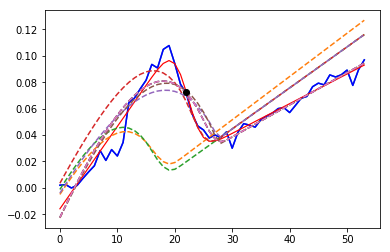

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 32
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00304443
    reduced chi-square = 6.4775e-05
    Akaike info crit   = -514.305049
    Bayesian info crit = -500.382160
[[Variables]]
    t0:     21.9066384 +/- 0.22530657 (1.03%) (init = 26.88145)
    sigma: -1.35148118 +/- 0.28952057 (21.42%) (init = -1.043089)
    alpha: -0.19344007 +/- 3589193.89 (1855455224.75%) (init = -15.54601)
    a1:    -0.01127957 +/- 0.00918027 (81.39%) (init = -0.03203317)
    a2:     0.00423763 +/- 2.1617e-04 (5.10%) (init = 0.006944501)
    a5:    -7.8164e-04 +/- 3.2763e-04 (41.92%) (init = -0.002714179)
    a6:     2.43785688 +/- 1.46477249 (60.08%) (init = 0.349145)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)    =  0.956
    C(a5, a6)    = -0.894
    C(a1, a5)    = -0.828
    C(alpha, a2) = -0.510
    C(t0, a5)    =

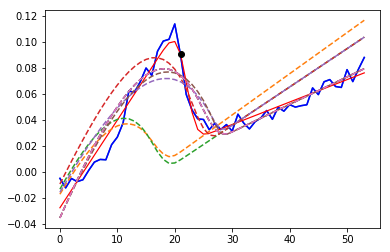

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 700
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00146265
    reduced chi-square = 1.8283e-05
    Akaike info crit   = -942.426917
    Bayesian info crit = -925.165560
[[Variables]]
    t0:     51.1882667 +/- 0.33892572 (0.66%) (init = 48.87127)
    sigma: -0.79503500 +/- 0.59671791 (75.06%) (init = -0.8370895)
    alpha: -22.1919648 +/- 6.11151727 (27.54%) (init = -3.582613)
    a1:     10.4328347 +/- 1229.04311 (11780.53%) (init = -0.04124583)
    a2:     2.7898e-04 +/- 3.9920e-04 (143.10%) (init = -0.00162014)
    a5:     2.8583e-04 +/- 4.1705e-04 (145.91%) (init = 0.001317837)
    a6:     37162.4668 +/- 4353247.43 (11714.10%) (init = 73.64311)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  1.000
    C(alpha, a1)    = -0.988
    C(alpha, a6)    = -0.988
    C(a5, a6)       = -0.984
    

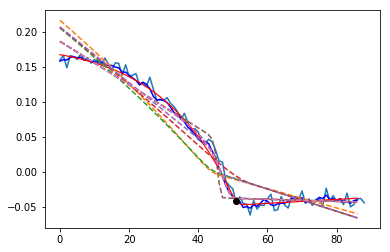

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 220
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00241257
    reduced chi-square = 3.0157e-05
    Akaike info crit   = -898.888309
    Bayesian info crit = -881.626952
[[Variables]]
    t0:     52.9713647 +/- 0.53997497 (1.02%) (init = 49.74)
    sigma: -1.43584089 +/- 0.67761173 (47.19%) (init = -0.5396714)
    alpha: -14.9597517 +/- 4.30491775 (28.78%) (init = -2.874059)
    a1:     0.04378742 +/- 0.07158159 (163.48%) (init = -0.03883801)
    a2:     4.3684e-05 +/- 2.9747e-04 (680.97%) (init = -0.001256817)
    a5:     0.00111959 +/- 3.4584e-04 (30.89%) (init = 0.001219507)
    a6:     216.170579 +/- 124.623641 (57.65%) (init = 79.1083)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)       =  0.996
    C(alpha, a6)    = -0.980
    C(a1, a6)       =  0.975
    C(alpha, a1)    = -0.974
    C(alpha, 

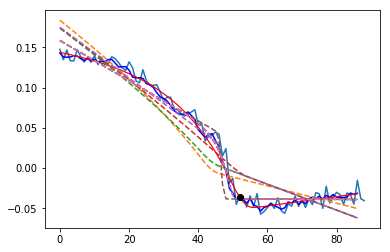

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 57
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00134490
    reduced chi-square = 2.6371e-05
    Akaike info crit   = -604.968790
    Bayesian info crit = -590.545689
[[Variables]]
    t0:     31.9995957 +/- 1.40902774 (4.40%) (init = 34.00002)
    sigma: -0.67428584 +/- 0.87197574 (129.32%) (init = -6.646145e-06)
    alpha: -1.55345026 +/- 1.47907312 (95.21%) (init = -12.49052)
    a1:     0.15433857 +/- 0.00418833 (2.71%) (init = 0.1577369)
    a2:     5.3541e-04 +/- 1.0211e-04 (19.07%) (init = 0.001183506)
    a5:    -0.00156486 +/- 2.3774e-04 (15.19%) (init = -0.00239397)
    a6:     9.28536938 +/- 2.68446021 (28.91%) (init = 9.566549)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  0.966
    C(t0, alpha)    = -0.963
    C(a5, a6)       = -0.941
    C(a1, a5)       = -0.930
    C(t0, si

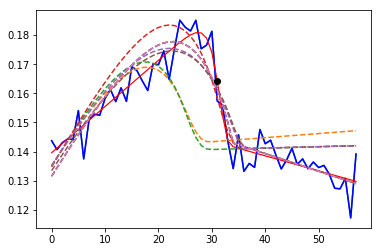

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 24
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00119573
    reduced chi-square = 2.3446e-05
    Akaike info crit   = -611.787782
    Bayesian info crit = -597.364681
[[Variables]]
    t0:     31.9251825 +/- 0.45152735 (1.41%) (init = 36.33278)
    sigma: -1.98142371 +/- 0.59696028 (30.13%) (init = -0.002614305)
    alpha: -0.80179200 +/- 1.27000140 (158.40%) (init = -17.4755)
    a1:     0.14523074 +/- 0.00561230 (3.86%) (init = 0.1516587)
    a2:     3.1915e-04 +/- 1.0521e-04 (32.97%) (init = 0.001215501)
    a5:    -0.00152094 +/- 2.6894e-04 (17.68%) (init = -0.002867109)
    a6:    -0.74950934 +/- 4.65486217 (621.05%) (init = 5.243912)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.986
    C(a1, a6)       =  0.943
    C(a1, a5)       = -0.936
    C(a1, a2)       = -0.845
    C(t0, al

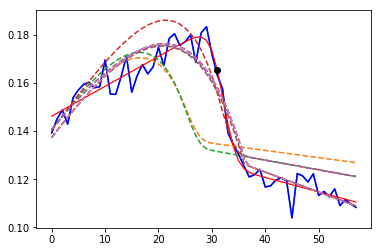

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 22
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00176624
    reduced chi-square = 3.7580e-05
    Akaike info crit   = -543.705759
    Bayesian info crit = -529.782871
[[Variables]]
    t0:     21.7772469 (init = 26.62978)
    sigma: -1.98038631 (init = -0.7886177)
    alpha: -0.22280632 (init = -16.00349)
    a1:    -0.03500176 (init = -0.04332222)
    a2:     0.00344496 (init = 0.005633259)
    a5:     8.2773e-06 (init = -0.001783571)
    a6:    -2.64417755 (init = -2.083051)



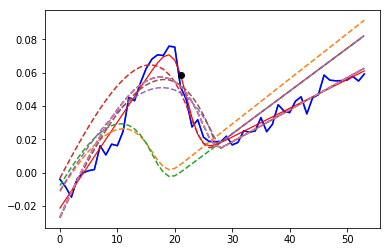

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 28
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00258829
    reduced chi-square = 5.5070e-05
    Akaike info crit   = -523.070135
    Bayesian info crit = -509.147247
[[Variables]]
    t0:     21.7046936 (init = 26.7194)
    sigma: -1.49454520 (init = -1.308417)
    alpha: -0.08678663 (init = -15.97335)
    a1:    -0.02376957 (init = -0.04136036)
    a2:     0.00330096 (init = 0.005646639)
    a5:    -5.1935e-04 (init = -0.002188682)
    a6:     0.24862130 (init = -1.242427)



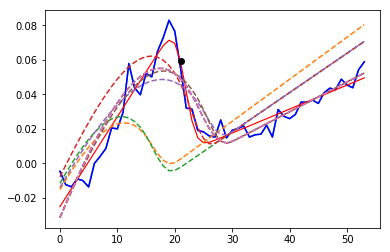

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 43
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00129347
    reduced chi-square = 1.6168e-05
    Akaike info crit   = -953.120922
    Bayesian info crit = -935.859565
[[Variables]]
    t0:     51.2265087 +/- 0.41999191 (0.82%) (init = 48.49311)
    sigma: -1.53564368 +/- 0.47764021 (31.10%) (init = -1.022948)
    alpha: -12.0589191 +/- 2.26385389 (18.77%) (init = -3.325734)
    a1:     0.00357286 +/- 0.01993399 (557.93%) (init = -0.03775241)
    a2:    -2.1327e-04 +/- 1.6994e-04 (79.69%) (init = -0.001252083)
    a5:     0.00100986 +/- 2.0682e-04 (20.48%) (init = 0.00102328)
    a6:     175.419601 +/- 49.5364507 (28.24%) (init = 81.66115)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)       =  0.998
    C(alpha, a6)    = -0.969
    C(a2, a6)       =  0.936
    C(alpha, a2)    = -0.935
    C(alpha, 

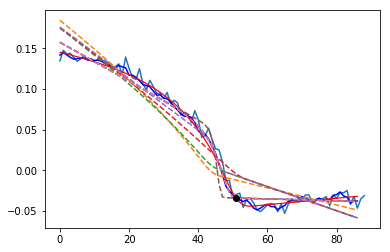

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 50
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00390943
    reduced chi-square = 4.8868e-05
    Akaike info crit   = -856.893592
    Bayesian info crit = -839.632235
[[Variables]]
    t0:     48.4071381 +/- 0.57261026 (1.18%) (init = 47.6339)
    sigma: -2.96092058 +/- 0.79643957 (26.90%) (init = -2.016164)
    alpha: -1.38122144 +/- 0.89199838 (64.58%) (init = -0.4462358)
    a1:    -0.03088570 +/- 0.00233160 (7.55%) (init = -0.03748876)
    a2:    -7.1049e-04 +/- 8.3033e-05 (11.69%) (init = -0.001059234)
    a5:     0.00172369 +/- 2.1040e-04 (12.21%) (init = 0.0009068382)
    a6:     85.5699888 +/- 2.97116260 (3.47%) (init = 84.79034)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)       =  0.898
    C(t0, alpha)    = -0.792
    C(sigma, alpha) = -0.703
    C(t0, sigma)    =  0.638
    C(a2, a5) 

/home/carminati_c/anaconda3/lib/python3.6/site-packages/lmfit/minimizer.py:767: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/carminati_c/anaconda3/lib/python3.6/site-packages/lmfit/minimizer.py:774: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


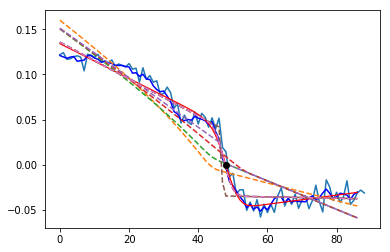

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 29
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00164006
    reduced chi-square = 3.2158e-05
    Akaike info crit   = -593.460849
    Bayesian info crit = -579.037748
[[Variables]]
    t0:     30.6846939 (init = 35.61088)
    sigma: -1.45869392 (init = -0.02681697)
    alpha: -0.20531159 (init = -16.03004)
    a1:     0.12725945 (init = 0.1270005)
    a2:     5.0330e-04 (init = 0.001210796)
    a5:    -0.00138384 (init = -0.002058714)
    a6:     8.45280359 (init = 7.337948)



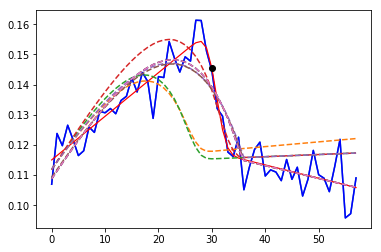

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 22
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00181256
    reduced chi-square = 3.5540e-05
    Akaike info crit   = -587.660468
    Bayesian info crit = -573.237367
[[Variables]]
    t0:     31.6799489 +/- 0.63536852 (2.01%) (init = 36.20928)
    sigma: -2.53693522 +/- 0.86190934 (33.97%) (init = -0.4964194)
    alpha: -1.04943274 +/- 1.73985409 (165.79%) (init = -17.12477)
    a1:     0.10538194 +/- 0.01205043 (11.44%) (init = 0.1153246)
    a2:     4.4335e-04 +/- 1.4112e-04 (31.83%) (init = 0.001257133)
    a5:    -8.6831e-04 +/- 3.5856e-04 (41.29%) (init = -0.002217451)
    a6:    -15.1886847 +/- 11.7274688 (77.21%) (init = 0.3451604)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.991
    C(a1, a5)       = -0.948
    C(a1, a6)       =  0.926
    C(a1, a2)       = -0.813
    C(t0, al

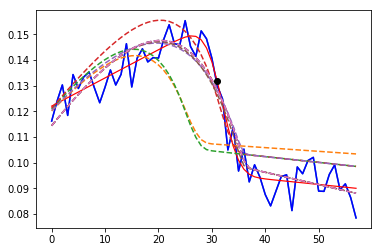

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 25
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00189411
    reduced chi-square = 4.0300e-05
    Akaike info crit   = -539.931480
    Bayesian info crit = -526.008592
[[Variables]]
    t0:     21.9244673 (init = 26.87451)
    sigma: -1.92250798 (init = -1.121702)
    alpha: -0.16073431 (init = -16.73744)
    a1:    -0.04642302 (init = -0.05524011)
    a2:     0.00310856 (init = 0.005208634)
    a5:     7.9944e-05 (init = -0.001602901)
    a6:    -3.12896734 (init = -2.476294)



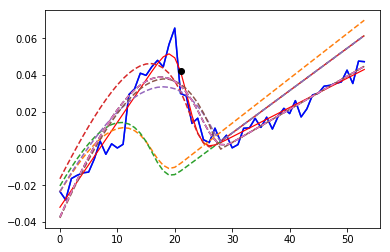

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 30
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00185417
    reduced chi-square = 3.9450e-05
    Akaike info crit   = -541.082277
    Bayesian info crit = -527.159389
[[Variables]]
    t0:     21.7438286 (init = 26.63657)
    sigma: -1.65457936 (init = -1.085229)
    alpha: -0.08648725 (init = -16.28002)
    a1:    -0.04119647 (init = -0.05579753)
    a2:     0.00307280 (init = 0.005314521)
    a5:    -3.8765e-04 (init = -0.002054032)
    a6:    -0.48508120 (init = -1.464603)



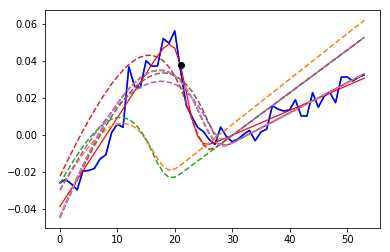

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 18
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00137650
    reduced chi-square = 1.7206e-05
    Akaike info crit   = -947.708401
    Bayesian info crit = -930.447044
[[Variables]]
    t0:     50.6209612 +/- 0.29397420 (0.58%) (init = 48.57739)
    sigma: -0.25951875 +/- 1.10614050 (426.23%) (init = -0.8140788)
    alpha: -8.89804816 +/- 1.15606519 (12.99%) (init = -3.209924)
    a1:    -0.01790820 +/- 0.00663604 (37.06%) (init = -0.03584309)
    a2:    -3.4959e-04 +/- 9.4834e-05 (27.13%) (init = -0.0009748965)
    a5:     7.2969e-04 +/- 1.3816e-04 (18.93%) (init = 0.0006477428)
    a6:     153.175121 +/- 25.0515759 (16.35%) (init = 90.70691)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, a6)    = -0.924
    C(a1, a2)       =  0.901
    C(alpha, a2)    = -0.849
    C(a2, a6)       =  0.828
    C(a5,

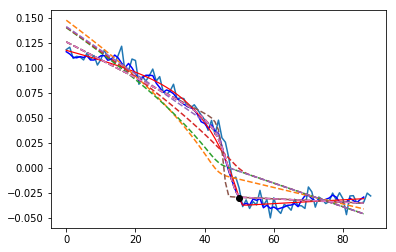

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 33
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00246392
    reduced chi-square = 3.0799e-05
    Akaike info crit   = -897.055980
    Bayesian info crit = -879.794623
[[Variables]]
    t0:     51.3452372 +/- 0.61752424 (1.20%) (init = 49.6867)
    sigma: -1.26380844 +/- 0.56392759 (44.62%) (init = -1.060268)
    alpha: -5.05706962 +/- 1.00380911 (19.85%) (init = -2.995344)
    a1:    -0.00987691 +/- 0.00617629 (62.53%) (init = -0.033722)
    a2:    -2.0534e-04 +/- 8.0350e-05 (39.13%) (init = -0.0005597858)
    a5:     0.00111373 +/- 1.6829e-04 (15.11%) (init = 0.0005539667)
    a6:     126.369530 +/- 11.8582695 (9.38%) (init = 121.7565)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)       =  0.992
    C(t0, alpha)    = -0.865
    C(alpha, a6)    = -0.772
    C(a5, a6)       = -0.711
    C(t0, sigma

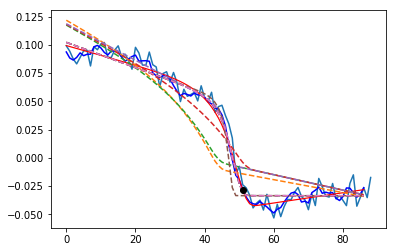

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 42
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00158845
    reduced chi-square = 3.1146e-05
    Akaike info crit   = -595.315457
    Bayesian info crit = -580.892356
[[Variables]]
    t0:     30.2669787 (init = 34.23989)
    sigma: -1.65145438 (init = -0.001948703)
    alpha: -0.20662181 (init = -11.1797)
    a1:     0.11600860 (init = 0.1167866)
    a2:     2.9996e-04 (init = 0.0007293239)
    a5:    -0.00138870 (init = -0.001830171)
    a6:     10.6320336 (init = 9.534379)



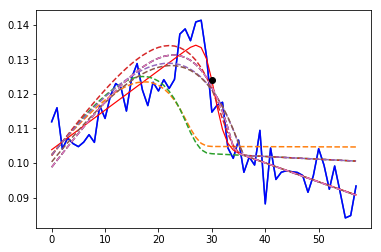

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 136
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00144918
    reduced chi-square = 2.8415e-05
    Akaike info crit   = -600.637678
    Bayesian info crit = -586.214577
[[Variables]]
    t0:     31.4832522 (init = 36.99995)
    sigma: -1.33841423 (init = -1.373734e-05)
    alpha: -0.06178504 (init = -17.51667)
    a1:     0.09904339 (init = 0.09777613)
    a2:     2.0567e-04 (init = 0.0009153352)
    a5:    -8.7979e-04 (init = -0.001644572)
    a6:    -8.79750874 (init = -1.013665)



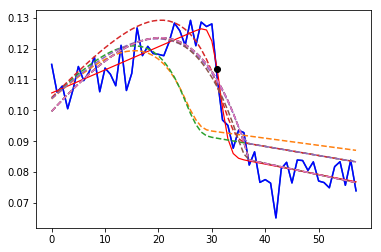

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 26
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00162294
    reduced chi-square = 3.4531e-05
    Akaike info crit   = -548.275073
    Bayesian info crit = -534.352184
[[Variables]]
    t0:     21.5327167 +/- 0.29293043 (1.36%) (init = 26.76955)
    sigma: -1.75152221 +/- 0.33855263 (19.33%) (init = -1.449638)
    alpha: -0.26561502 +/- 972640.824 (366184423.31%) (init = -16.673)
    a1:    -0.00560925 +/- 0.00721141 (128.56%) (init = -0.02514323)
    a2:     0.00320691 +/- 2.0809e-04 (6.49%) (init = 0.005372231)
    a5:    -4.6299e-04 +/- 2.7911e-04 (60.28%) (init = -0.001921402)
    a6:     1.77105341 +/- 1.55690269 (87.91%) (init = -0.7335742)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)    =  0.952
    C(a5, a6)    = -0.856
    C(a1, a5)    = -0.758
    C(alpha, a2) = -0.709
    C(t0, a5)    =

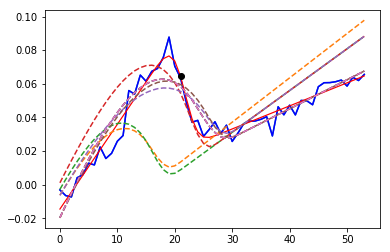

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 34
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00261749
    reduced chi-square = 5.5691e-05
    Akaike info crit   = -522.464273
    Bayesian info crit = -508.541385
[[Variables]]
    t0:     21.5540405 (init = 26.61318)
    sigma: -1.34521940 (init = -1.319395)
    alpha: -0.13729815 (init = -15.90555)
    a1:     0.00523088 (init = -0.01607654)
    a2:     0.00305796 (init = 0.00521473)
    a5:    -0.00112043 (init = -0.002461298)
    a6:     5.34893263 (init = 1.598539)



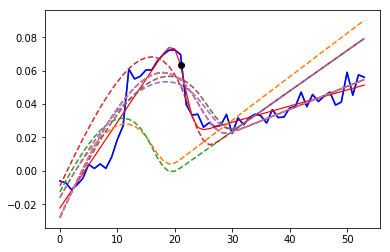

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 25
    # data points      = 87
    # variables        = 7
    chi-square         = 8.9751e-04
    reduced chi-square = 1.1219e-05
    Akaike info crit   = -984.915753
    Bayesian info crit = -967.654396
[[Variables]]
    t0:     51.4676916 +/- 0.43956491 (0.85%) (init = 49.67702)
    sigma: -1.62637394 +/- 0.42807639 (26.32%) (init = -0.7827785)
    alpha: -8.38689431 +/- 1.20266709 (14.34%) (init = -4.773956)
    a1:     0.00155254 +/- 0.00899846 (579.60%) (init = -0.03241723)
    a2:    -1.2526e-04 +/- 7.9919e-05 (63.80%) (init = -0.0006125528)
    a5:     9.2537e-04 +/- 1.2463e-04 (13.47%) (init = 0.00053458)
    a6:     154.920669 +/- 22.0389814 (14.23%) (init = 117.0801)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)       =  0.998
    C(alpha, a6)    = -0.915
    C(alpha, a1)    = -0.844
    C(alpha, a2)    = -0.822
    C(t0, a

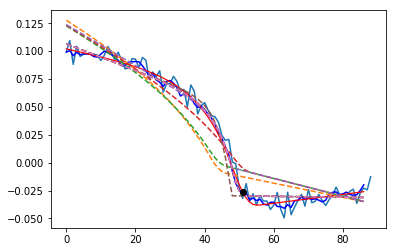

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 34
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00206381
    reduced chi-square = 2.5798e-05
    Akaike info crit   = -912.472726
    Bayesian info crit = -895.211369
[[Variables]]
    t0:     50.6220605 +/- 0.70250623 (1.39%) (init = 50.82825)
    sigma: -1.23274297 +/- 0.53419892 (43.33%) (init = -0.585774)
    alpha: -3.67418454 +/- 0.89599195 (24.39%) (init = -5.206676)
    a1:    -0.02131143 +/- 0.00619724 (29.08%) (init = -0.0628578)
    a2:    -2.6820e-04 +/- 6.3806e-05 (23.79%) (init = -0.0003406246)
    a5:     6.3002e-04 +/- 1.4486e-04 (22.99%) (init = 5.453162e-05)
    a6:     148.373338 +/- 15.9132386 (10.73%) (init = 270.6129)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)       =  0.918
    C(t0, alpha)    = -0.917
    C(t0, sigma)    =  0.777
    C(a5, a6)       = -0.763
    C(a1, a5

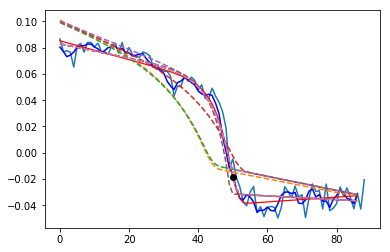

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 67
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00137900
    reduced chi-square = 2.7039e-05
    Akaike info crit   = -603.516726
    Bayesian info crit = -589.093625
[[Variables]]
    t0:     28.7822877 (init = 36)
    sigma: -1.86003811 (init = -1.192712e-07)
    alpha: -0.08368078 (init = -19.08087)
    a1:     0.10038736 (init = 0.09784495)
    a2:     2.6515e-04 (init = 0.0007585478)
    a5:    -0.00152051 (init = -0.001759116)
    a6:     14.3624122 (init = 10.393)



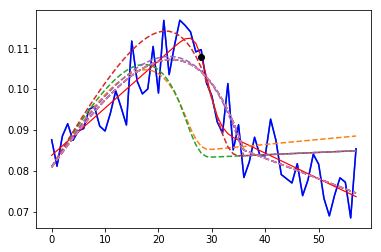

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 45
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00160146
    reduced chi-square = 3.1401e-05
    Akaike info crit   = -594.842508
    Bayesian info crit = -580.419407
[[Variables]]
    t0:     32.5886282 (init = 37.00387)
    sigma: -3.13697553 (init = -0.7329118)
    alpha: -0.21977645 (init = -18.27424)
    a1:     0.01482129 (init = 0.06313118)
    a2:     6.5756e-04 (init = 0.001168058)
    a5:     1.4773e-04 (init = -0.001226894)
    a6:    -65.8739879 (init = -2.868798)



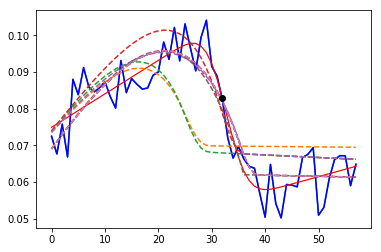

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 24
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00104126
    reduced chi-square = 2.2154e-05
    Akaike info crit   = -572.240848
    Bayesian info crit = -558.317959
[[Variables]]
    t0:     22.0144269 (init = 27.09667)
    sigma: -2.12942202 (init = -1.277529)
    alpha: -0.18688943 (init = -16.78757)
    a1:    -0.03894755 (init = -0.04313405)
    a2:     0.00218626 (init = 0.003633441)
    a5:     1.9058e-04 (init = -0.0009869722)
    a6:    -5.88382887 (init = -3.879947)



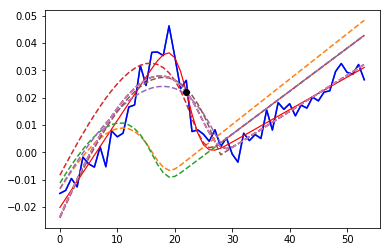

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 34
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00146528
    reduced chi-square = 3.1176e-05
    Akaike info crit   = -553.793244
    Bayesian info crit = -539.870356
[[Variables]]
    t0:     21.7536746 +/- 0.50670188 (2.33%) (init = 26.77595)
    sigma: -0.87893257 +/- 0.57802434 (65.76%) (init = -1.504256)
    alpha: -0.42220393 +/- 0.70663653 (167.37%) (init = -15.81206)
    a1:    -0.03146771 +/- 0.00666414 (21.18%) (init = -0.04520183)
    a2:     0.00201952 +/- 1.2743e-04 (6.31%) (init = 0.003555071)
    a5:    -3.0800e-04 +/- 2.1340e-04 (69.29%) (init = -0.001317853)
    a6:    -0.82952711 +/- 2.36214726 (284.76%) (init = -2.445962)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.949
    C(a1, a6)       =  0.940
    C(a1, a5)       = -0.886
    C(t0, alpha)    = -0.872
    C(t0, s

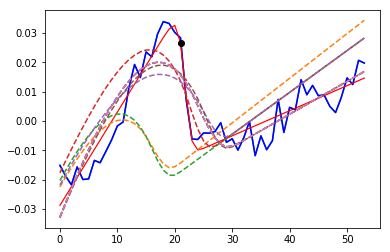

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 31
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00123784
    reduced chi-square = 1.5473e-05
    Akaike info crit   = -956.945402
    Bayesian info crit = -939.684045
[[Variables]]
    t0:     49.3465813 +/- 1.15266742 (2.34%) (init = 48.62611)
    sigma: -2.24218356 +/- 0.70264529 (31.34%) (init = -1.476283)
    alpha: -5.17681679 +/- 1.50307402 (29.03%) (init = -5.097844)
    a1:    -0.02067925 +/- 0.00657573 (31.80%) (init = -0.06986122)
    a2:    -2.7320e-04 +/- 6.7603e-05 (24.74%) (init = -0.0004436588)
    a5:     4.4045e-04 +/- 1.2619e-04 (28.65%) (init = -4.970366e-05)
    a6:     167.804649 +/- 28.0904670 (16.74%) (init = 241.6131)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, alpha)    = -0.951
    C(t0, sigma)    =  0.875
    C(sigma, alpha) = -0.833
    C(alpha, a6)    = -0.807
    C(a5, 

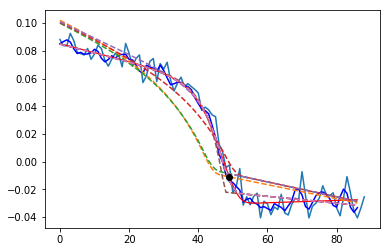

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 30
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00164754
    reduced chi-square = 2.0594e-05
    Akaike info crit   = -932.070835
    Bayesian info crit = -914.809478
[[Variables]]
    t0:     50.8600925 +/- 0.34647420 (0.68%) (init = 51.92378)
    sigma: -0.76546735 +/- 0.40126171 (52.42%) (init = -0.3915826)
    alpha: -5.02864925 +/- 0.50254803 (9.99%) (init = -7.82764)
    a1:     118.284228 +/-        nan (nan%) (init = 215.7429)
    a2:     2.4655e-04 +/- 5.9750e-05 (24.23%) (init = 0.0004495224)
    a5:     2.4677e-04 +/- 5.2101e-05 (21.11%) (init = 0.0004497727)
    a6:     479752.398 +/-        nan (nan%) (init = 479941.8)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2, a5)       =  1.175
    C(t0, alpha)    = -0.877
    C(alpha, a5)    = -0.783
    C(alpha, a2)    = -0.572
    C(t0, a5)       

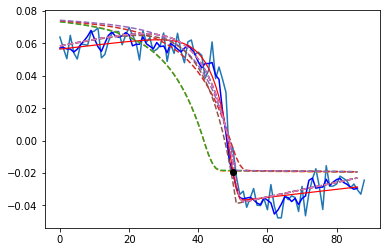

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 32
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00156118
    reduced chi-square = 3.0611e-05
    Akaike info crit   = -596.319779
    Bayesian info crit = -581.896678
[[Variables]]
    t0:     29.9085823 (init = 34.87259)
    sigma: -0.66529796 (init = -0.0275711)
    alpha: -0.07355659 (init = -14.06216)
    a1:     0.08626834 (init = 0.08354204)
    a2:     4.3796e-04 (init = 0.000936225)
    a5:    -9.2331e-04 (init = -0.001270986)
    a6:     7.99163698 (init = 5.510802)



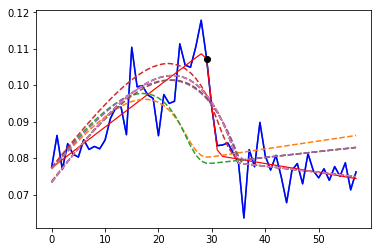

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 63
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00138867
    reduced chi-square = 2.7229e-05
    Akaike info crit   = -603.111524
    Bayesian info crit = -588.688423
[[Variables]]
    t0:     32.2154013 (init = 36.61102)
    sigma: -3.26172179 (init = -0.9770089)
    alpha: -0.15673664 (init = -17.22382)
    a1:    -0.00996581 (init = 0.05837717)
    a2:     5.6345e-04 (init = 0.001006324)
    a5:     2.5101e-04 (init = -0.000992011)
    a6:    -118.734102 (init = -6.774253)



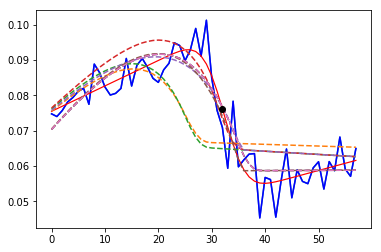

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 24
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00116752
    reduced chi-square = 2.4841e-05
    Akaike info crit   = -566.060325
    Bayesian info crit = -552.137436
[[Variables]]
    t0:     21.5198972 +/- 0.35675820 (1.66%) (init = 26.31472)
    sigma: -1.92235930 +/- 0.44540031 (23.17%) (init = -0.8268003)
    alpha: -0.26923106 +/- 22967398.3 (8530738637.83%) (init = -15.31256)
    a1:    -0.02358579 +/- 0.00721685 (30.60%) (init = -0.02971476)
    a2:     0.00206350 +/- 1.3282e-04 (6.44%) (init = 0.003344266)
    a5:    -1.0281e-04 +/- 2.0390e-04 (198.34%) (init = -0.001122246)
    a6:    -1.80981102 +/- 2.53126929 (139.86%) (init = -1.851619)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.949
    C(a1, a6)       =  0.945
    C(a1, a5)       = -0.878
    C(t0, a5)       =  0.565
  

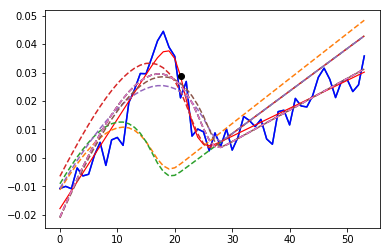

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 29
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00142823
    reduced chi-square = 3.0388e-05
    Akaike info crit   = -555.176508
    Bayesian info crit = -541.253620
[[Variables]]
    t0:     21.2344964 (init = 26.07723)
    sigma: -1.39311121 (init = -0.8575543)
    alpha: -0.16941391 (init = -15.29313)
    a1:    -0.01133245 (init = -0.02390178)
    a2:     0.00197353 (init = 0.003418169)
    a5:    -8.1384e-04 (init = -0.001766828)
    a6:     4.32174130 (init = 1.133192)



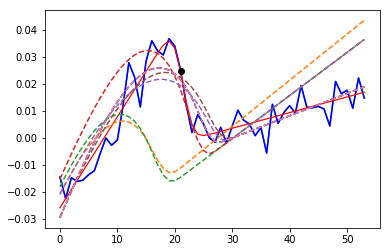

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 17
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00119130
    reduced chi-square = 1.4891e-05
    Akaike info crit   = -960.279680
    Bayesian info crit = -943.018323
[[Variables]]
    t0:     48.8052800 +/- 0.48988547 (1.00%) (init = 48.80493)
    sigma: -1.04674678 +/- 0.42190107 (40.31%) (init = -0.610029)
    alpha: -3.83615135 +/- 0.69480742 (18.11%) (init = -4.572057)
    a1:    -0.02802303 +/- 0.00667350 (23.81%) (init = -0.06243078)
    a2:    -3.0863e-04 +/- 4.8670e-05 (15.77%) (init = -0.0003462546)
    a5:     3.2356e-04 +/- 1.0225e-04 (31.60%) (init = 8.65303e-06)
    a6:     175.761771 +/- 22.2397449 (12.65%) (init = 272.9139)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5)       =  0.916
    C(t0, alpha)    = -0.890
    C(a5, a6)       = -0.782
    C(t0, sigma)    =  0.717
    C(sigma,

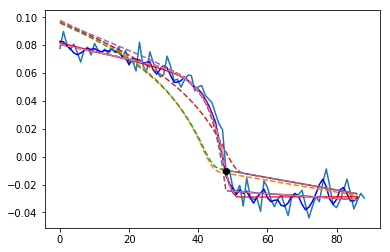

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 144
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00190661
    reduced chi-square = 2.3833e-05
    Akaike info crit   = -919.365336
    Bayesian info crit = -902.103979
[[Variables]]
    t0:     49.3725217 +/- 0.60474106 (1.22%) (init = 51.50063)
    sigma: -0.89054423 +/- 0.41464562 (46.56%) (init = -0.01368723)
    alpha: -2.26482731 +/- 0.65411232 (28.88%) (init = -8.990712)
    a1:     0.00512286 +/- 0.08859511 (1729.41%) (init = -0.01258623)
    a2:     5.0497e-06 +/- 5.2993e-05 (1049.42%) (init = 0.000355945)
    a5:    -5.2944e-05 +/- 1.2616e-04 (238.30%) (init = -0.0006430575)
    a6:    -1554.46587 +/- 2973.47293 (191.29%) (init = -73.3195)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)       = -0.983
    C(t0, alpha)    = -0.945
    C(a5, a6)       = -0.915
    C(t0, sigma)    =  0.844
   

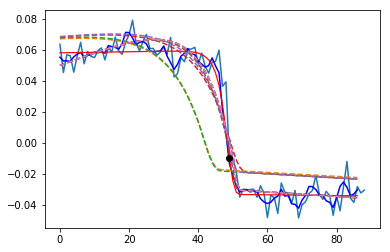

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 32
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00136208
    reduced chi-square = 2.6708e-05
    Akaike info crit   = -604.232632
    Bayesian info crit = -589.809530
[[Variables]]
    t0:     30.6976493 (init = 35.24976)
    sigma: -1.58225176 (init = -0.03080802)
    alpha: -0.10425947 (init = -14.74532)
    a1:     0.05648490 (init = 0.06011342)
    a2:     6.7504e-04 (init = 0.001161662)
    a5:    -2.8093e-04 (init = -0.0008699645)
    a6:    -4.90639638 (init = 1.114378)



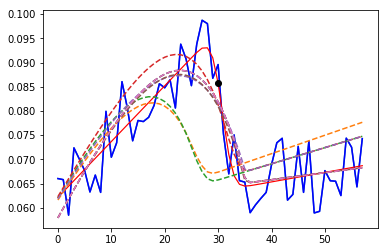

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 700
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00188508
    reduced chi-square = 3.6962e-05
    Akaike info crit   = -585.385119
    Bayesian info crit = -570.962018
[[Variables]]
    t0:     33.6901855 +/- 4.21431074 (12.51%) (init = 36.08064)
    sigma: -1.50155695 +/- 2.32102655 (154.57%) (init = -0.01568653)
    alpha: -2.77238221 +/- 4.26013563 (153.66%) (init = -16.66657)
    a1:     0.00536688 +/- 0.05567570 (1037.39%) (init = 0.0379622)
    a2:     6.0753e-04 +/- 1.5987e-04 (26.31%) (init = 0.001136261)
    a5:     1.9822e-04 +/- 3.6187e-04 (182.56%) (init = -0.0006271306)
    a6:    -68.9976460 +/- 80.3383869 (116.44%) (init = -10.45811)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a5)       = -0.999
    C(t0, alpha)    = -0.977
    C(a1, a6)       =  0.964
    C(a5, a6)       = -0.961
   

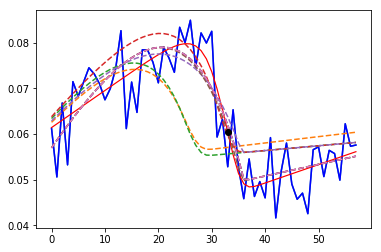

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 32
    # data points      = 54
    # variables        = 7
    chi-square         = 8.5517e-04
    reduced chi-square = 1.8195e-05
    Akaike info crit   = -582.872298
    Bayesian info crit = -568.949410
[[Variables]]
    t0:     22.6699380 (init = 27.63195)
    sigma: -2.90872887 (init = -1.249633)
    alpha: -0.39065834 (init = -17.30691)
    a1:    -0.05229802 (init = -0.03727133)
    a2:     0.00178197 (init = 0.002918936)
    a5:     6.0123e-04 (init = -0.0005435566)
    a6:    -19.6850203 (init = -7.230382)



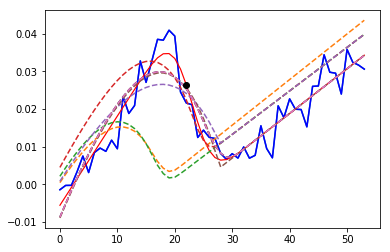

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 43
    # data points      = 54
    # variables        = 7
    chi-square         = 8.7440e-04
    reduced chi-square = 1.8604e-05
    Akaike info crit   = -581.671405
    Bayesian info crit = -567.748516
[[Variables]]
    t0:     23.1080696 +/- 2.35895260 (10.21%) (init = 26.53544)
    sigma: -0.90541042 +/- 1.26138373 (139.32%) (init = -1.033245)
    alpha: -1.42915784 +/- 2.01029488 (140.66%) (init = -16.3872)
    a1:    -0.02815875 +/- 0.00664018 (23.58%) (init = -0.03331246)
    a2:     0.00170171 +/- 1.2437e-04 (7.31%) (init = 0.003161084)
    a5:    -9.9102e-05 +/- 1.9153e-04 (193.26%) (init = -0.001275329)
    a6:    -5.27443257 +/- 3.07954646 (58.39%) (init = -3.234416)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, alpha)    = -0.987
    C(t0, sigma)    =  0.972
    C(a5, a6)       = -0.968
    C(sigma, alpha) = -0.947
    C(a1, 

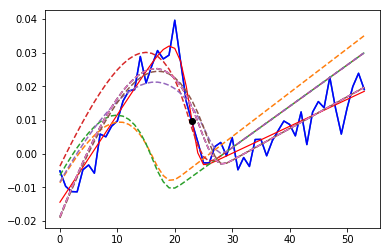

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 17
    # data points      = 87
    # variables        = 7
    chi-square         = 7.3894e-04
    reduced chi-square = 9.2367e-06
    Akaike info crit   = -1001.82994
    Bayesian info crit = -984.568586
[[Variables]]
    t0:     49.4429339 +/- 0.30406711 (0.61%) (init = 50.10876)
    sigma: -0.92984095 +/- 0.33909444 (36.47%) (init = -0.5584472)
    alpha: -5.84738009 +/- 0.47677080 (8.15%) (init = -7.694011)
    a1:    -38.5370178 +/- 7244.71989 (18799.38%) (init = 14.26694)
    a2:    -6.9410e-05 +/- 4.2519e-05 (61.26%) (init = 2.564443e-05)
    a5:    -6.9245e-05 +/- 4.8776e-05 (70.44%) (init = 2.582241e-05)
    a6:     555526.296 +/- 1.0443e+08 (18797.66%) (init = 555538.8)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       = -1.000
    C(t0, alpha)    = -0.858
    C(a2, a5)       =  0.778
    C(alpha, a2)    = -0.575
    C(t0,

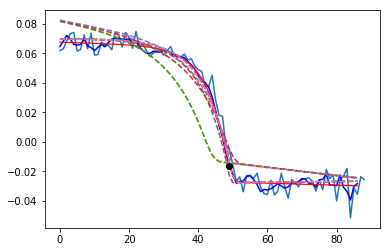

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 36
    # data points      = 87
    # variables        = 7
    chi-square         = 6.6365e-04
    reduced chi-square = 8.2956e-06
    Akaike info crit   = -1011.17855
    Bayesian info crit = -993.917196
[[Variables]]
    t0:     49.2441750 +/- 0.36827150 (0.75%) (init = 51.61382)
    sigma: -0.83888783 +/- 0.23595756 (28.13%) (init = -0.04273242)
    alpha: -1.90104193 +/- 0.36952803 (19.44%) (init = -9.285887)
    a1:    -0.02816668 +/- 0.01412313 (50.14%) (init = -0.01497164)
    a2:     1.4903e-04 +/- 3.0423e-05 (20.41%) (init = 0.0005600389)
    a5:    -1.8113e-04 +/- 7.3474e-05 (40.56%) (init = -0.0008756724)
    a6:    -246.928887 +/- 55.4338489 (22.45%) (init = -43.12938)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, alpha)    = -0.958
    C(a1, a5)       = -0.953
    C(a5, a6)       = -0.942
    C(t0, sigma)    =  0.880
    C(si

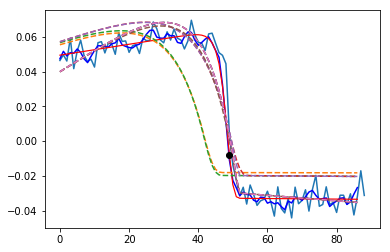

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 32
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00120700
    reduced chi-square = 2.3667e-05
    Akaike info crit   = -611.243379
    Bayesian info crit = -596.820278
[[Variables]]
    t0:     31.0901241 (init = 35.12899)
    sigma: -1.88083229 (init = -1.193137e-08)
    alpha: -0.13770473 (init = -12.54534)
    a1:     0.05804170 (init = 0.06530269)
    a2:     6.3998e-04 (init = 0.0009667491)
    a5:    -3.1866e-04 (init = -0.0009161166)
    a6:    -3.02440929 (init = 4.263032)



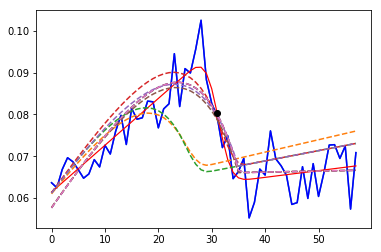

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 37
    # data points      = 58
    # variables        = 7
    chi-square         = 0.00147029
    reduced chi-square = 2.8829e-05
    Akaike info crit   = -599.798763
    Bayesian info crit = -585.375662
[[Variables]]
    t0:     34.9999974 +/- 1.07783014 (3.08%) (init = 36)
    sigma: -3.9602e-07 +/- 4311657.87 (1088744779513000.62%) (init = -5.465152e-08)
    alpha: -4.39066431 +/- 2.07912982 (47.35%) (init = -17.10215)
    a1:     0.05659117 +/- 0.00926527 (16.37%) (init = 0.05910504)
    a2:     3.8157e-04 +/- 1.3437e-04 (35.22%) (init = 0.0008638007)
    a5:    -4.6552e-04 +/- 2.7286e-04 (58.62%) (init = -0.001042882)
    a6:    -11.3512897 +/- 12.6150022 (111.13%) (init = -2.023553)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)    = -0.988
    C(a1, a5)    = -0.910
    C(a1, a6)    =  0.900
    C(a1, a2)    = -0.648
    C(t0, a

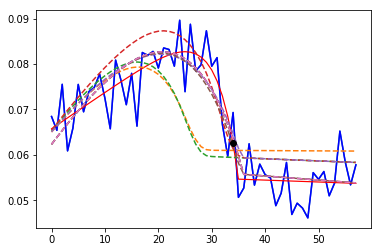

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 22
    # data points      = 54
    # variables        = 7
    chi-square         = 9.1457e-04
    reduced chi-square = 1.9459e-05
    Akaike info crit   = -579.246293
    Bayesian info crit = -565.323405
[[Variables]]
    t0:     22.2122705 (init = 26.70128)
    sigma: -1.80870489 (init = -0.9270146)
    alpha: -0.08419955 (init = -16.41235)
    a1:    -0.02907382 (init = -0.0284137)
    a2:     0.00168798 (init = 0.002939703)
    a5:     2.8013e-04 (init = -0.000804236)
    a6:    -9.12705962 (init = -4.27879)



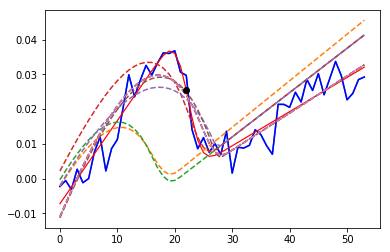

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 42
    # data points      = 54
    # variables        = 7
    chi-square         = 0.00112509
    reduced chi-square = 2.3938e-05
    Akaike info crit   = -568.059373
    Bayesian info crit = -554.136485
[[Variables]]
    t0:     21.6675778 (init = 26.7976)
    sigma: -0.95198202 (init = -0.8942645)
    alpha: -0.06100233 (init = -16.78168)
    a1:    -0.00904130 (init = -0.0210874)
    a2:     0.00162152 (init = 0.003055481)
    a5:    -4.9763e-04 (init = -0.001457803)
    a6:     1.10987266 (init = -1.152792)



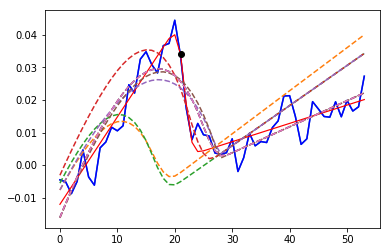

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 36
    # data points      = 87
    # variables        = 7
    chi-square         = 7.2832e-04
    reduced chi-square = 9.1040e-06
    Akaike info crit   = -1003.08855
    Bayesian info crit = -985.827195
[[Variables]]
    t0:     49.6247090 +/- 0.36441020 (0.73%) (init = 50.21154)
    sigma: -1.25801569 +/- 0.35311155 (28.07%) (init = -0.5125982)
    alpha: -6.42473941 +/- 0.75270459 (11.72%) (init = -9.898691)
    a1:    -0.01143250 +/- 0.02690873 (235.37%) (init = -0.004009309)
    a2:     5.7548e-05 +/- 5.0860e-05 (88.38%) (init = 0.000222491)
    a5:    -1.1642e-04 +/- 9.0650e-05 (77.87%) (init = -0.0004898529)
    a6:    -532.247786 +/- 335.036127 (62.95%) (init = -115.2248)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.894
    C(t0, alpha)    = -0.845
    C(alpha, a6)    = -0.742
    C(a1, a2)       = -0.726
    C(al

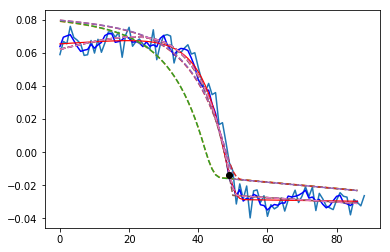

[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 201
    # data points      = 87
    # variables        = 7
    chi-square         = 0.00105713
    reduced chi-square = 1.3214e-05
    Akaike info crit   = -970.674947
    Bayesian info crit = -953.413590
[[Variables]]
    t0:     47.6949470 +/- 0.40456486 (0.85%) (init = 51.95735)
    sigma: -3.45379625 +/- 0.46743284 (13.53%) (init = -0.6881656)
    alpha: -1.91493822 +/- 0.42219716 (22.05%) (init = -10.32166)
    a1:    -1.34936761 +/- 5.37687836 (398.47%) (init = -0.03697583)
    a2:     3.1058e-04 +/- 4.5879e-05 (14.77%) (init = 0.0006132358)
    a5:     2.8651e-04 +/- 1.1405e-04 (39.81%) (init = -0.0005322846)
    a6:    -4340.11441 +/- 17137.3052 (394.86%) (init = -68.13922)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a6)       =  0.999
    C(a1, a5)       = -0.936
    C(a5, a6)       = -0.923
    C(t0, alpha)    = -0.857
    C(

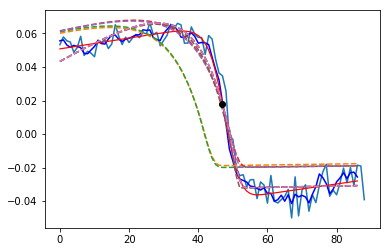

In [9]:
est_sigma=-1
est_alpha=-10

results_stress_304_220 = [dict() for x in range(len(stress_304))]
results_stress_316_220 = [dict() for x in range(len(stress_304))]

results_stress_304_200 = [dict() for x in range(len(stress_304))]
results_stress_316_200 = [dict() for x in range(len(stress_304))]

results_stress_304_111 = [dict() for x in range(len(stress_304))]
results_stress_316_111 = [dict() for x in range(len(stress_304))]

for i in range(0, len(stress_304)):
    results_stress_304_200[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(stress304_spectrum_binned[i]), myrange_200, peak_position_200, est_sigma, est_alpha, False, False)
    results_stress_316_200[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(stress316_spectrum_binned[i]), myrange_200, peak_position_200, est_sigma,  est_alpha, False, False)
    results_stress_304_220[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(stress304_spectrum_binned[i]), myrange_220, peak_position_220, est_sigma, est_alpha, False, False)
    results_stress_316_220[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(stress316_spectrum_binned[i]), myrange_220, peak_position_220, est_sigma,  est_alpha, False, False)
    results_stress_304_111[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(stress304_spectrum_binned[i]), myrange_111, peak_position_111, est_sigma, est_alpha, False, True)
    results_stress_316_111[i] = AdvancedBraggEdgeFitting.AdvancedBraggEdgeFitting(-1*np.log(stress316_spectrum_binned[i]), myrange_111, peak_position_111, est_sigma,  est_alpha, False, True)    

## Here I produce the pictures with the results

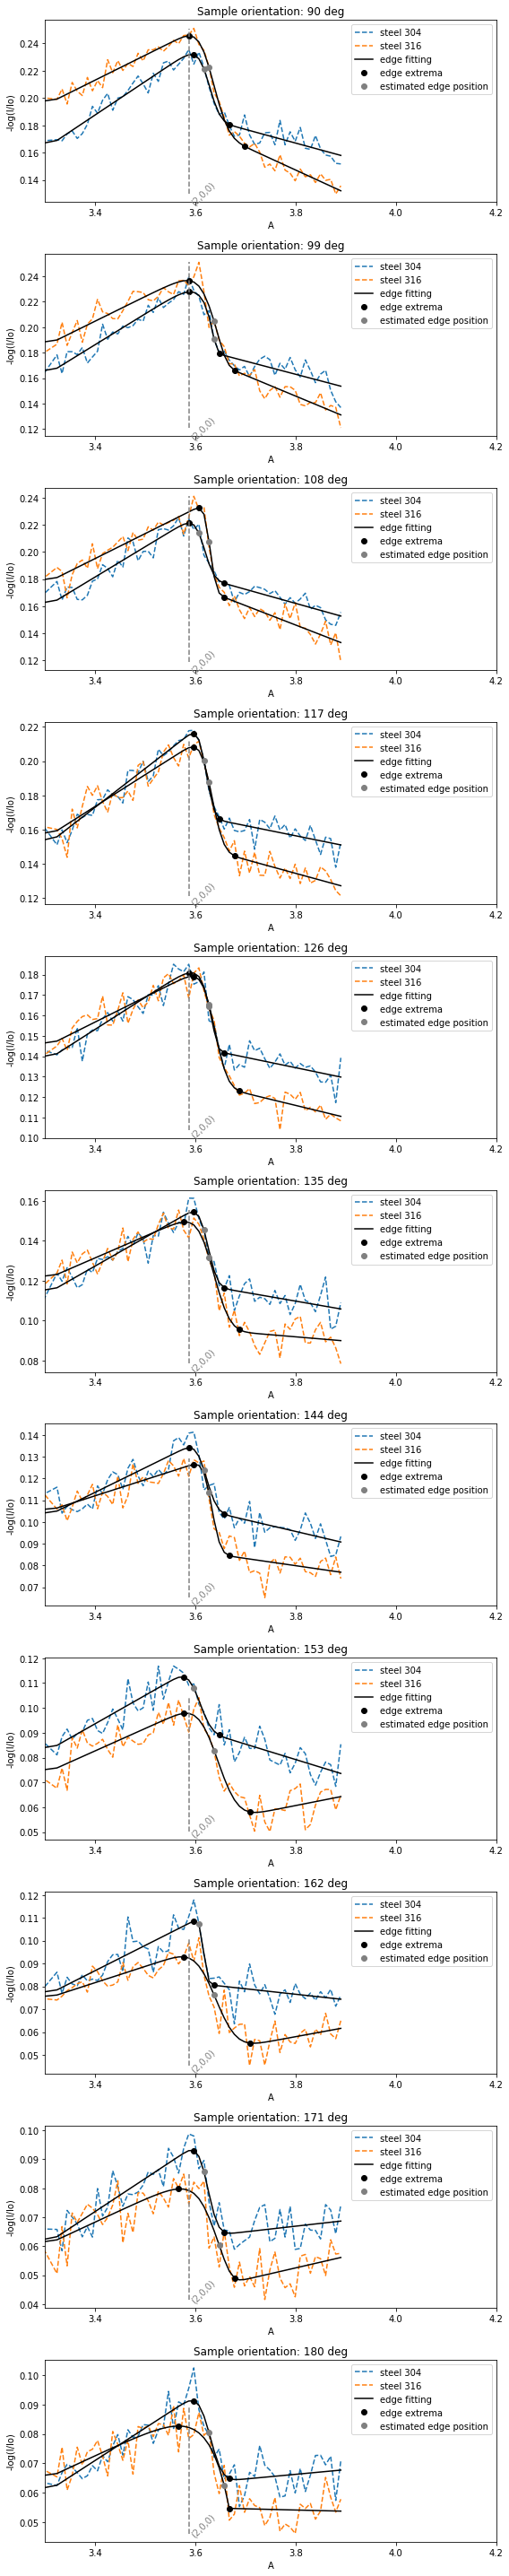

In [10]:
# Here I prepare the picture to summarize the results on the (2,0,0) Austenite peak
fig, ax = plt.subplots(11,1,figsize=[8,40])
peak_height_304_200=[]
peak_height_316_200=[]
    
labels = np.chararray(11)
labels=('90','99','108','117','126','135','144','153','162','171','180')

for i in range(0,len(results_stress_304_200)):


    results_304 = results_stress_304_200[i]['final_result']
    fitted_data_304=results_stress_304_200[i]['fitted_data']
    pos_extrema_304 = results_stress_304_200[i]['pos_extrema']  
    pos_peak_304 = results_stress_304_200[i]['t0']
    peak_height_304_200.append( fitted_data_304[pos_extrema_304[0]]-fitted_data_304[pos_extrema_304[1]])


    results_316 = results_stress_316_200[i]['final_result']
    fitted_data_316=results_stress_316_200[i]['fitted_data']
    pos_extrema_316 = results_stress_316_200[i]['pos_extrema']  
    pos_peak_316 = results_stress_316_200[i]['t0']
    peak_height_316_200.append(fitted_data_316[pos_extrema_316[0]]-fitted_data_316[pos_extrema_316[1]])


    ax[i].plot(mylambda_binned[myrange_200[0]:myrange_200[1]],-1*np.log(stress304_spectrum_binned[i][myrange_200[0]:myrange_200[1]]),'--', label='steel 304')
    ax[i].plot(mylambda_binned[myrange_200[0]:myrange_200[1]],-1*np.log(stress316_spectrum_binned[i][myrange_200[0]:myrange_200[1]]),'--', label='steel 316')
#     ax[i].plot(mylambda_binned[myrange[0]:myrange[1]-2],AdvancedBraggEdgeFitting.running_mean(-1*np.log(stress304_spectrum_binned[i][myrange[0]:myrange[1]]),3), label='smoothed steel 304')
#     ax[i].plot(mylambda_binned[myrange[0]:myrange[1]-2],AdvancedBraggEdgeFitting.running_mean(-1*np.log(stress316_spectrum_binned[i][myrange[0]:myrange[1]]),3), label='smoothed steel 316')
    ax[i].plot(mylambda_binned[myrange_200[0]:myrange_200[1]],fitted_data_304,'k', label='edge fitting')
    ax[i].plot(mylambda_binned[myrange_200[0]:myrange_200[1]],fitted_data_316,'k')
    ax[i].plot(mylambda_binned[myrange_200[0]+pos_extrema_304[0:2]],fitted_data_304[pos_extrema_304[0:2]],'ok', label='edge extrema')
    ax[i].plot(mylambda_binned[myrange_200[0]+pos_extrema_316[0:2]],fitted_data_316[pos_extrema_316[0:2]],'ok')
    ax[i].plot(mylambda_binned[myrange_200[0]+int(pos_peak_304)], fitted_data_304[int(pos_peak_304)],'o', color='gray', label='estimated edge position')
    ax[i].plot(mylambda_binned[myrange_200[0]+int(pos_peak_316)], fitted_data_316[int(pos_peak_316)],'o', color='gray')


    ax[i].set_xlabel('A')
    ax[i].set_xlim(3.3, 4.2)
    # plt.ylim(0, 0.4)
    ax[i].set_ylabel('-log(I/Io)')
    ax[i].set_title('Sample orientation: '+str(labels[i])+' deg')
    ax[i].legend(loc='upper right')
    
    ax[i].plot(np.array([2*dhkl_gammaFe[1],2*dhkl_gammaFe[1]]), np.array([np.min(-1*np.log(stress316_spectrum_binned[i][myrange_200[0]:myrange_200[1]])), np.max(-1*np.log(stress316_spectrum_binned[i][myrange_200[0]:myrange_200[1]]))]), '--', color='gray')
    mytext = '('+str((h_gammaFe[1]).astype(int))+','+str(k_gammaFe[1].astype(int))+','+str(l_gammaFe[1].astype(int))+')'
    ax[i].text(2*dhkl_gammaFe[1],np.min(-1*np.log(stress316_spectrum_binned[i][myrange_200[0]:myrange_200[1]]))+0.005, mytext, rotation=45, color='gray')

fig.tight_layout()
fig.savefig('Edge_fitting_200.eps', format='eps', dpi=400)
np.savetxt('peak_height_304_200.txt', peak_height_304_200)
np.savetxt('peak_height_316_200.txt', peak_height_316_200)

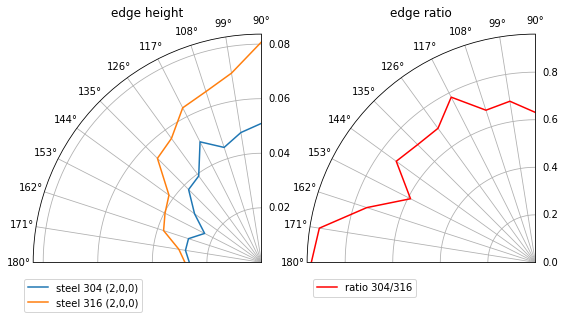

In [11]:
angles=[90,99,108,117,126,135,144,153,162,171,180]
theta=[]
ratio=[]
for i in range(0,11):
    theta.append( np.pi / 180 * float(angles[i]))
    ratio.append(peak_height_304_200[i]/peak_height_316_200[i])
fig = plt.figure( figsize=[9,6])
ax=fig.add_subplot(121,polar='True')
ax.plot(theta, peak_height_304_200, label='steel 304 (2,0,0)')
ax.plot(theta, peak_height_316_200, label='steel 316 (2,0,0)')
# plt.polar(theta, peak_height_304, label='steel 304 (2,2,0)')
# plt.polar(theta, peak_height_316, label='steel 316 (2,2,0)')
ax.set_yticks([0.02,0.04,0.06,0.08])
ax.set_xticks(theta)
ax.set_thetamin(90)
ax.set_thetamax(180)
plt.title('edge height')
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))

ax=fig.add_subplot(122,polar='True')
ax.plot(theta, ratio,'r', label='ratio 304/316')
ax.set_thetamin(90)
ax.set_thetamax(180)
ax.set_xticks(theta)
plt.title('edge ratio')
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))

fig.savefig('polar_peakheight_200.eps', format='eps', dpi=400)

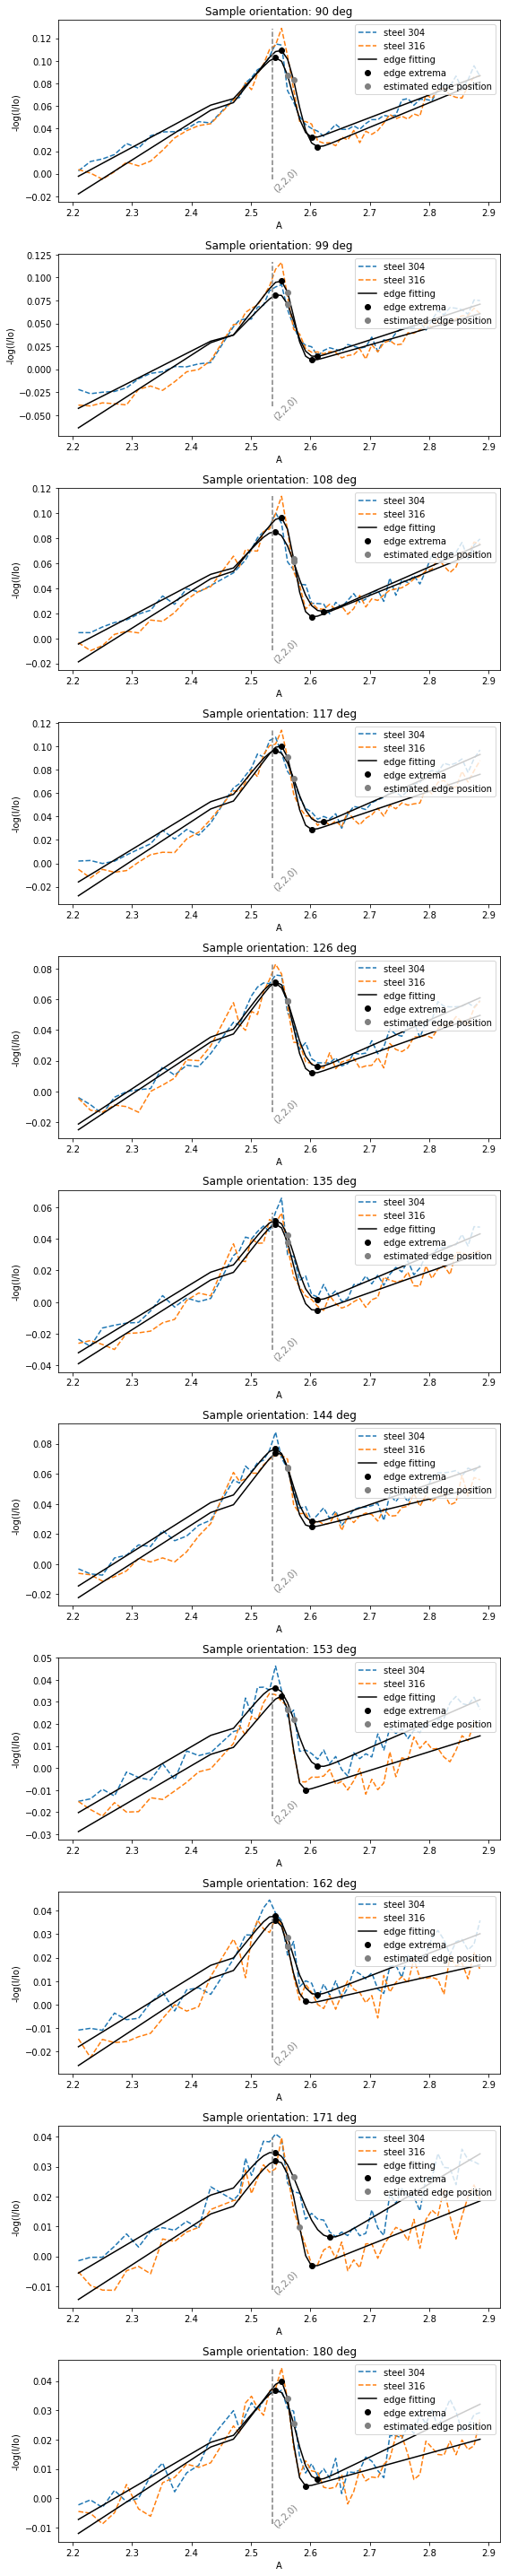

In [12]:
# Here I prepare the picture to summarize the results on the (2,0,0) Austenite peak
fig, ax = plt.subplots(11,1,figsize=[8,40])
peak_height_304_220=[]
peak_height_316_220=[]
    
labels = np.chararray(11)
labels=('90','99','108','117','126','135','144','153','162','171','180')

for i in range(0,len(results_stress_304_220)):


    results_304 = results_stress_304_220[i]['final_result']
    fitted_data_304=results_stress_304_220[i]['fitted_data']
    pos_extrema_304 = results_stress_304_220[i]['pos_extrema']  
    pos_peak_304 = results_stress_304_220[i]['t0']
    peak_height_304_220.append( fitted_data_304[pos_extrema_304[0]]-fitted_data_304[pos_extrema_304[1]])


    results_316 = results_stress_316_220[i]['final_result']
    fitted_data_316=results_stress_316_220[i]['fitted_data']
    pos_extrema_316 = results_stress_316_220[i]['pos_extrema']  
    pos_peak_316 = results_stress_316_220[i]['t0']
    peak_height_316_220.append(fitted_data_316[pos_extrema_316[0]]-fitted_data_316[pos_extrema_316[1]])

    ax[i].plot(mylambda_binned[myrange_220[0]:myrange_220[1]],-1*np.log(stress304_spectrum_binned[i][myrange_220[0]:myrange_220[1]]),'--', label='steel 304')
    ax[i].plot(mylambda_binned[myrange_220[0]:myrange_220[1]],-1*np.log(stress316_spectrum_binned[i][myrange_220[0]:myrange_220[1]]),'--', label='steel 316')
#     ax[i].plot(mylambda_binned[myrange[0]:myrange[1]],AdvancedBraggEdgeFitting.running_mean(-1*np.log(stress304_spectrum_binned[i][myrange[0]:myrange[1]]),3), label='smoothed steel 304')
#     ax[i].plot(mylambda_binned[myrange[0]:myrange[1]],AdvancedBraggEdgeFitting.running_mean(-1*np.log(stress316_spectrum_binned[i][myrange[0]:myrange[1]]),3), label='smoothed steel 316')
    ax[i].plot(mylambda_binned[myrange_220[0]:myrange_220[1]],fitted_data_304,'k', label='edge fitting')
    ax[i].plot(mylambda_binned[myrange_220[0]:myrange_220[1]],fitted_data_316,'k')
    ax[i].plot(mylambda_binned[myrange_220[0]+pos_extrema_304[0:2]],fitted_data_304[pos_extrema_304[0:2]],'ok', label='edge extrema')
    ax[i].plot(mylambda_binned[myrange_220[0]+pos_extrema_316[0:2]],fitted_data_316[pos_extrema_316[0:2]],'ok')
    ax[i].plot(mylambda_binned[myrange_220[0]+int(pos_peak_304)], fitted_data_304[int(pos_peak_304)],'o', color='gray', label='estimated edge position')
    ax[i].plot(mylambda_binned[myrange_220[0]+int(pos_peak_316)], fitted_data_316[int(pos_peak_316)],'o', color='gray')


    ax[i].set_xlabel('A')
    ax[i].set_ylabel('-log(I/Io)')
    ax[i].set_title('Sample orientation: '+str(labels[i])+' deg')
    ax[i].legend(loc='upper right')
    
    ax[i].plot(np.array([2*dhkl_gammaFe[2],2*dhkl_gammaFe[2]]), np.array([np.min(-1*np.log(stress316_spectrum_binned[i][myrange_220[0]:myrange_220[1]])), np.max(-1*np.log(stress316_spectrum_binned[i][myrange_220[0]:myrange_220[1]]))]), '--', color='gray')
    mytext = '('+str((h_gammaFe[2]).astype(int))+','+str(k_gammaFe[2].astype(int))+','+str(l_gammaFe[2].astype(int))+')'
    ax[i].text(2*dhkl_gammaFe[2],np.min(-1*np.log(stress316_spectrum_binned[i][myrange_220[0]:myrange_220[1]]))+0.005, mytext, rotation=45, color='gray')

fig.tight_layout()
fig.savefig('Edge_fitting_220.eps', format='eps', dpi=400)

np.savetxt('peak_height_304_220.txt', peak_height_304_220)
np.savetxt('peak_height_316_220.txt', peak_height_316_220)

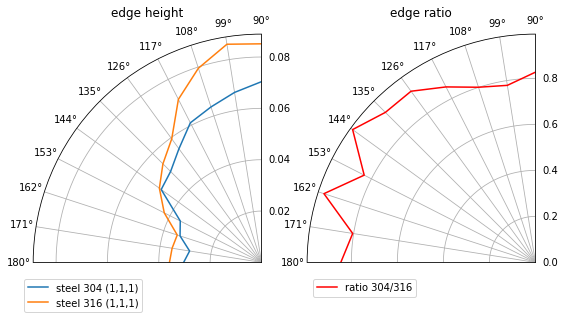

In [13]:
angles=[90,99,108,117,126,135,144,153,162,171,180]
theta=[]
ratio=[]
for i in range(0,11):
    theta.append( np.pi / 180 * float(angles[i]))
    ratio.append(peak_height_304_220[i]/peak_height_316_220[i])
fig = plt.figure( figsize=[9,6])
ax=fig.add_subplot(121,polar='True')

ax.plot(theta, peak_height_304_220, label='steel 304 (1,1,1)')
ax.plot(theta, peak_height_316_220, label='steel 316 (1,1,1)')
# plt.polar(theta, peak_height_304, label='steel 304 (2,2,0)')
# plt.polar(theta, peak_height_316, label='steel 316 (2,2,0)')
ax.set_yticks([0.02,0.04,0.06,0.08])
ax.set_xticks(theta)
ax.set_thetamin(90)
ax.set_thetamax(180)
plt.title('edge height')
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))

ax=fig.add_subplot(122,polar='True')
ax.plot(theta, ratio,'r', label='ratio 304/316')
ax.set_thetamin(90)
ax.set_thetamax(180)
ax.set_xticks(theta)
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))
plt.title('edge ratio')

fig.savefig('polar_peakheight_220.eps', format='eps', dpi=400)

[0, 62]
[0, 59]
[0, 56]
[0, 60]
[52]
[0, 56]
[52]
[55]
[54]
[0, 55]
[0, 51]
[0, 54]
[0, 54]
[0, 53]
[0, 54]
[28, 52]
[0, 51]
[33, 51]
[0, 51]
[39, 51]
[20, 52]
[35, 56]


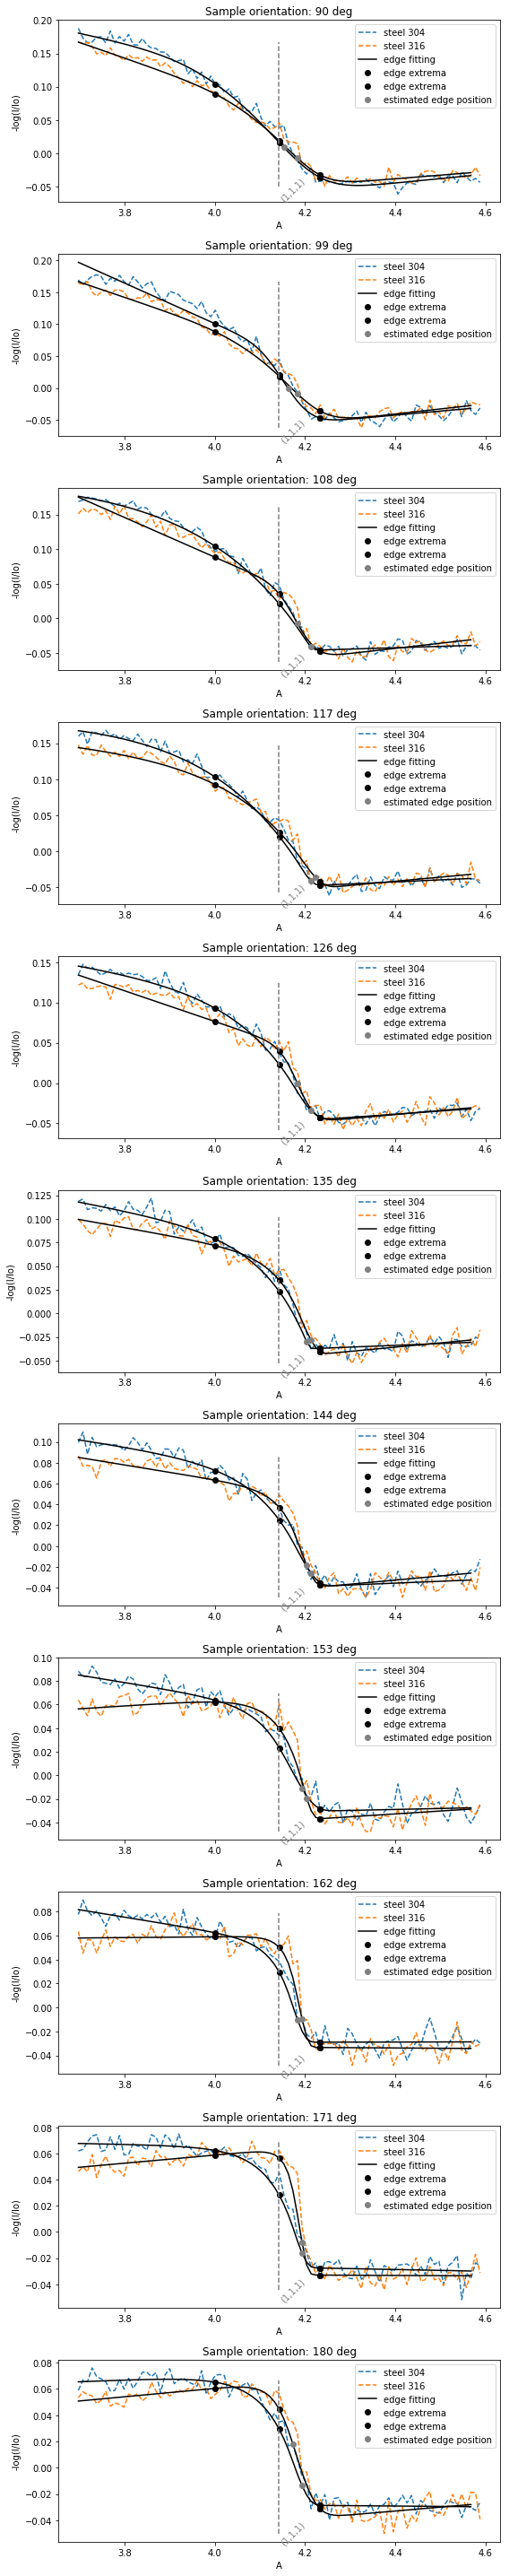

In [14]:
fig, ax = plt.subplots(11,1,figsize=[8,40])
peak_height_304_110=[]
peak_height_316_110=[]

peak_height_304_111=[]
peak_height_316_111=[]
    
labels = np.chararray(11)
labels=('90','99','108','117','126','135','144','153','162','171','180')
defined_height_pos_110 = np.array([30,53])
defined_height_pos_111 = np.array([find_nearest(mylambda_binned,2*dhkl_gammaFe[0])-myrange_111[0],53])

for i in range(0,len(results_stress_304_111)):


    results_304 = results_stress_304_111[i]['final_result']
    fitted_data_304=results_stress_304_111[i]['fitted_data']
    pos_extrema_304 = results_stress_304_111[i]['pos_extrema'] 
    print(pos_extrema_304)
    pos_peak_304 = results_stress_304_111[i]['t0']
    
    defined_height_pos_110 = np.array([30,53])
    defined_height_pos_111 = np.array([find_nearest(mylambda_binned,2*dhkl_gammaFe[0])-myrange_111[0],53])

    results_316 = results_stress_316_111[i]['final_result']
    fitted_data_316=results_stress_316_111[i]['fitted_data']
    pos_extrema_316 = results_stress_316_111[i]['pos_extrema']  
    print(pos_extrema_316)
    pos_peak_316 = results_stress_316_111[i]['t0']

    if defined_height_pos_111[1]< pos_peak_304:
        defined_height_pos_111[1]=pos_peak_304
    elif defined_height_pos_111[1] < pos_peak_316:
        defined_height_pos_111[1] = pos_peak_316
        
    if defined_height_pos_110[1]< pos_peak_304:
        defined_height_pos_110[1]=pos_peak_304
    elif defined_height_pos_110[1] < pos_peak_316:
        defined_height_pos_110[1] = pos_peak_316
        
    peak_height_316_110.append(fitted_data_316[defined_height_pos_110[0]]-fitted_data_316[defined_height_pos_110[1]])
    peak_height_316_111.append(fitted_data_316[defined_height_pos_111[0]]-fitted_data_316[defined_height_pos_111[1]])
                

    peak_height_304_110.append( fitted_data_304[defined_height_pos_110[0]]-fitted_data_304[defined_height_pos_110[1]])
    peak_height_304_111.append( fitted_data_304[defined_height_pos_111[0]]-fitted_data_304[defined_height_pos_111[1]])
        
#     print(peak_height_304, peak_height_316)

    # start with one
#     plt.figure()
    ax[i].plot(mylambda_binned[myrange_111[0]:myrange_111[1]],-1*np.log(stress304_spectrum_binned[i][myrange_111[0]:myrange_111[1]]),'--', label='steel 304')
    ax[i].plot(mylambda_binned[myrange_111[0]:myrange_111[1]],-1*np.log(stress316_spectrum_binned[i][myrange_111[0]:myrange_111[1]]),'--', label='steel 316')
#     ax[i].plot(mylambda_binned[myrange[0]:myrange[1]],AdvancedBraggEdgeFitting.running_mean(-1*np.log(stress304_spectrum_binned[i][myrange[0]:myrange[1]]),3), label='smoothed steel 304')
#     ax[i].plot(mylambda_binned[myrange[0]:myrange[1]],AdvancedBraggEdgeFitting.running_mean(-1*np.log(stress316_spectrum_binned[i][myrange[0]:myrange[1]]),3), label='smoothed steel 316')
    ax[i].plot(mylambda_binned[myrange_111[0]:myrange_111[1]-2],fitted_data_304,'k', label='edge fitting')
    ax[i].plot(mylambda_binned[myrange_111[0]:myrange_111[1]-2],fitted_data_316,'k')
    ax[i].plot(mylambda_binned[myrange_111[0]+defined_height_pos_111[0:2]],fitted_data_304[defined_height_pos_111[0:2]],'ok', label='edge extrema')
    ax[i].plot(mylambda_binned[myrange_111[0]+defined_height_pos_111[0:2]],fitted_data_316[defined_height_pos_111[0:2]],'ok')
    ax[i].plot(mylambda_binned[myrange_111[0]+defined_height_pos_110[0:2]],fitted_data_304[defined_height_pos_110[0:2]],'ok', label='edge extrema')
    ax[i].plot(mylambda_binned[myrange_111[0]+defined_height_pos_110[0:2]],fitted_data_316[defined_height_pos_110[0:2]],'ok')
    ax[i].plot(mylambda_binned[myrange_111[0]+int(pos_peak_304)], fitted_data_304[int(pos_peak_304)],'o', color='gray', label='estimated edge position')
    ax[i].plot(mylambda_binned[myrange_111[0]+int(pos_peak_316)], fitted_data_316[int(pos_peak_316)],'o', color='gray')


    ax[i].set_xlabel('A')
#     ax[i].set_xlim(3.3, 4.2)
    # plt.ylim(0, 0.4)
    ax[i].set_ylabel('-log(I/Io)')
    ax[i].set_title('Sample orientation: '+str(labels[i])+' deg')
    ax[i].legend(loc='upper right')
    
    ax[i].plot(np.array([2*dhkl_gammaFe[0],2*dhkl_gammaFe[0]]), np.array([np.min(-1*np.log(stress316_spectrum_binned[i][myrange_111[0]:myrange_111[1]])), np.max(-1*np.log(stress316_spectrum_binned[i][myrange_111[0]:myrange_111[1]]))]), '--', color='gray')
    mytext = '('+str((h_gammaFe[0]).astype(int))+','+str(k_gammaFe[0].astype(int))+','+str(l_gammaFe[0].astype(int))+')'
    ax[i].text(2*dhkl_gammaFe[0],np.min(-1*np.log(stress316_spectrum_binned[i][myrange_111[0]:myrange_111[1]]))+0.005, mytext, rotation=45, color='gray')

fig.tight_layout()
fig.savefig('Edge_fitting_111.eps', format='eps', dpi=400)

np.savetxt('peak_height_304_110.txt', peak_height_304_110)
np.savetxt('peak_height_316_110.txt', peak_height_316_110)

np.savetxt('peak_height_304_111.txt', peak_height_304_111)
np.savetxt('peak_height_316_111.txt', peak_height_316_111)


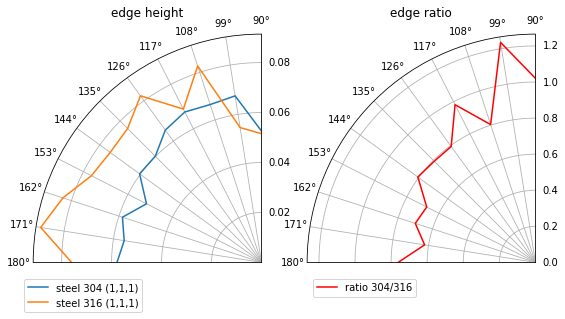

In [15]:
angles=[90,99,108,117,126,135,144,153,162,171,180]
theta=[]
ratio=[]
for i in range(0,11):
    theta.append( np.pi / 180 * float(angles[i]))
    ratio.append(peak_height_304_111[i]/peak_height_316_111[i])
fig = plt.figure( figsize=[9,6])
ax=fig.add_subplot(121,polar='True')

ax.plot(theta, peak_height_304_111, label='steel 304 (1,1,1)')
ax.plot(theta, peak_height_316_111, label='steel 316 (1,1,1)')
# plt.polar(theta, peak_height_304, label='steel 304 (2,2,0)')
# plt.polar(theta, peak_height_316, label='steel 316 (2,2,0)')
ax.set_yticks([0.02,0.04,0.06,0.08])
ax.set_xticks(theta)
ax.set_thetamin(90)
ax.set_thetamax(180)
plt.title('edge height')
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))

ax=fig.add_subplot(122,polar='True')
ax.plot(theta, ratio,'r', label='ratio 304/316')
ax.set_thetamin(90)
ax.set_thetamax(180)
ax.set_xticks(theta)
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))
plt.title('edge ratio')

fig.savefig('polar_peakheight_111.eps', format='eps', dpi=400)


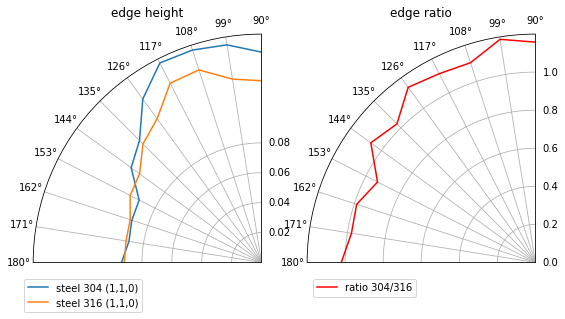

In [16]:
angles=[90,99,108,117,126,135,144,153,162,171,180]
theta=[]
ratio=[]
for i in range(0,11):
    theta.append( np.pi / 180 * float(angles[i]))
    ratio.append(peak_height_304_110[i]/peak_height_316_110[i])
fig = plt.figure( figsize=[9,6])
ax=fig.add_subplot(121,polar='True')

ax.plot(theta, peak_height_304_110, label='steel 304 (1,1,0)')
ax.plot(theta, peak_height_316_110, label='steel 316 (1,1,0)')
# plt.polar(theta, peak_height_304, label='steel 304 (2,2,0)')
# plt.polar(theta, peak_height_316, label='steel 316 (2,2,0)')
ax.set_yticks([0.02,0.04,0.06,0.08])
ax.set_xticks(theta)
ax.set_thetamin(90)
ax.set_thetamax(180)
plt.title('edge height')
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))

ax=fig.add_subplot(122,polar='True')
ax.plot(theta, ratio,'r', label='ratio 304/316')
ax.set_thetamin(90)
ax.set_thetamax(180)
ax.set_xticks(theta)
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))
plt.title('edge ratio')

fig.savefig('polar_peakheight_110.eps', format='eps', dpi=400)

## here i plot the edge height alltogether 

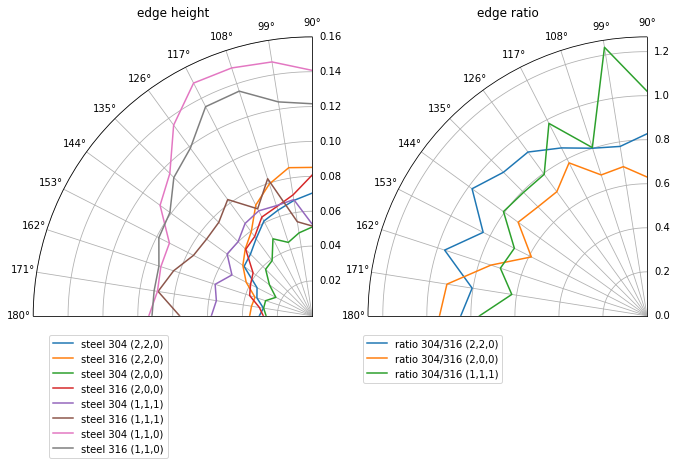

In [17]:
angles=[90,99,108,117,126,135,144,153,162,171,180]
theta=[]
ratio_220=[]
ratio_200=[]
ratio_111=[]
ratio_110=[]

for i in range(0,11):
    theta.append( np.pi / 180 * float(angles[i]))
    ratio_220.append(peak_height_304_220[i]/peak_height_316_220[i])
    ratio_200.append(peak_height_304_200[i]/peak_height_316_200[i])
    ratio_111.append(peak_height_304_111[i]/peak_height_316_111[i])
    ratio_110.append(peak_height_304_110[i]/peak_height_316_110[i])
    
fig = plt.figure( figsize=[11,8])
ax=fig.add_subplot(121,polar='True')
ax.plot(theta, peak_height_304_220, label='steel 304 (2,2,0)')
ax.plot(theta, peak_height_316_220, label='steel 316 (2,2,0)')
plt.polar(theta, peak_height_304_200, label='steel 304 (2,0,0)')
plt.polar(theta, peak_height_316_200, label='steel 316 (2,0,0)')
ax.plot(theta, peak_height_304_111, label='steel 304 (1,1,1)')
ax.plot(theta, peak_height_316_111, label='steel 316 (1,1,1)')
ax.plot(theta, peak_height_304_110, label='steel 304 (1,1,0)')
ax.plot(theta, peak_height_316_110, label='steel 316 (1,1,0)')
ax.set_yticks([0.02,0.04,0.06,0.08, 0.1, 0.12, 0.14, 0.16])
# ax.set_yticks([0.04,0.08,0.12,0.16, 0.20, 0.24])
ax.set_xticks(theta)
ax.set_thetamin(90)
ax.set_thetamax(180)
plt.title('edge height')
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))

ax=fig.add_subplot(122,polar='True')
ax.plot(theta, ratio_220, label='ratio 304/316 (2,2,0)')
ax.plot(theta, ratio_200, label='ratio 304/316 (2,0,0)')
ax.plot(theta, ratio_111, label='ratio 304/316 (1,1,1)')
# ax.plot(theta, ratio_110, label='ratio 304/316 (1,1,0)')
ax.set_thetamin(90)
ax.set_thetamax(180)
ax.set_xticks(theta)
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))
plt.title('edge ratio')
fig.savefig('Edge_plotting_all_stressed.eps', format='eps', dpi=400)

## here I produce a plot with the ratio of the edge height, computed for the ref and stress samples
### In this moment I don't see any improvement in the interpretation

In [18]:
ph_316_220_ref = np.loadtxt('/home/carminati_c/ownCloud/BeamTime2018/Results/Analysis_RefSamples_SpectraNormalized/peak_height_316_220.txt')
ph_304_220_ref = np.loadtxt('/home/carminati_c/ownCloud/BeamTime2018/Results/Analysis_RefSamples_SpectraNormalized/peak_height_304_220.txt')
ph_316_200_ref = np.loadtxt('/home/carminati_c/ownCloud/BeamTime2018/Results/Analysis_RefSamples_SpectraNormalized/peak_height_316_200.txt')
ph_304_200_ref = np.loadtxt('/home/carminati_c/ownCloud/BeamTime2018/Results/Analysis_RefSamples_SpectraNormalized/peak_height_304_200.txt')
ph_316_111_ref = np.loadtxt('/home/carminati_c/ownCloud/BeamTime2018/Results/Analysis_RefSamples_SpectraNormalized/peak_height_316_111.txt')
ph_304_111_ref = np.loadtxt('/home/carminati_c/ownCloud/BeamTime2018/Results/Analysis_RefSamples_SpectraNormalized/peak_height_304_111.txt')

ph_316_220_stress = np.loadtxt('/home/carminati_c/ownCloud/BeamTime2018/Results/Analysis_StressedSamples_SpectraNormalized/peak_height_316_220.txt')
ph_304_220_stress = np.loadtxt('/home/carminati_c/ownCloud/BeamTime2018/Results/Analysis_StressedSamples_SpectraNormalized/peak_height_304_220.txt')
ph_316_200_stress = np.loadtxt('/home/carminati_c/ownCloud/BeamTime2018/Results/Analysis_StressedSamples_SpectraNormalized/peak_height_316_200.txt')
ph_304_200_stress = np.loadtxt('/home/carminati_c/ownCloud/BeamTime2018/Results/Analysis_StressedSamples_SpectraNormalized/peak_height_304_200.txt')
ph_316_111_stress = np.loadtxt('/home/carminati_c/ownCloud/BeamTime2018/Results/Analysis_StressedSamples_SpectraNormalized/peak_height_316_111.txt')
ph_304_111_stress = np.loadtxt('/home/carminati_c/ownCloud/BeamTime2018/Results/Analysis_StressedSamples_SpectraNormalized/peak_height_304_111.txt')

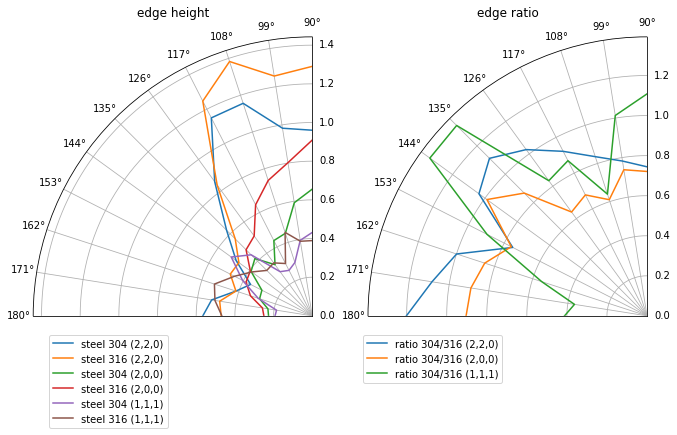

In [20]:
angles=[90,99,108,117,126,135,144,153,162,171,180]
theta=[]
nratio_220=[]
nratio_200=[]
nratio_111=[]

for i in range(0,11):
    theta.append( np.pi / 180 * float(angles[i]))
    nratio_220.append((ph_304_220_stress[i]/ph_304_220_ref[i])/(ph_316_220_stress[i]/ph_316_220_ref[i]))
    nratio_200.append((ph_304_200_stress[i]/ph_304_200_ref[i])/(ph_316_200_stress[i]/ph_316_200_ref[i]))
    nratio_111.append((ph_304_111_stress[i]/ph_304_111_ref[i])/(ph_316_111_stress[i]/ph_316_111_ref[i]))

fig = plt.figure( figsize=[11,8])
ax=fig.add_subplot(121,polar='True')
ax.plot(theta, ph_304_220_stress/ph_304_220_ref, label='steel 304 (2,2,0)')
ax.plot(theta, ph_316_220_stress/ph_316_220_ref, label='steel 316 (2,2,0)')
plt.polar(theta, ph_304_200_stress/ph_304_200_ref, label='steel 304 (2,0,0)')
plt.polar(theta, ph_316_200_stress/ph_316_200_ref, label='steel 316 (2,0,0)')
ax.plot(theta, ph_304_111_stress/ph_304_111_ref, label='steel 304 (1,1,1)')
ax.plot(theta, ph_316_111_stress/ph_316_111_ref, label='steel 316 (1,1,1)')
# ax.plot(theta, peak_height_304_110, label='steel 304 (1,1,0)')
# ax.plot(theta, peak_height_316_110, label='steel 316 (1,1,0)')
# ax.set_yticks([0.02,0.04,0.06,0.08, 0.1, 0.12, 0.14, 0.16])
# ax.set_yticks([0.04,0.08,0.12,0.16, 0.20, 0.24])
ax.set_xticks(theta)
ax.set_thetamin(90)
ax.set_thetamax(180)
plt.title('edge height')
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))

ax=fig.add_subplot(122,polar='True')
ax.plot(theta, nratio_220, label='ratio 304/316 (2,2,0)')
ax.plot(theta, nratio_200, label='ratio 304/316 (2,0,0)')
ax.plot(theta, nratio_111, label='ratio 304/316 (1,1,1)')
# ax.plot(theta, ratio_110, label='ratio 304/316 (1,1,0)')
ax.set_thetamin(90)
ax.set_thetamax(180)
ax.set_xticks(theta)
ax.legend(loc='best',bbox_to_anchor=(0.5, -0.05))
plt.title('edge ratio')
fig.savefig('Normalized_Edge_plotting_all.eps', format='eps', dpi=400)    